In [1]:
import os
import os.path as osp
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Dataset

## 1.1. Amino acid distribution

In [17]:
def distribution_aa(data, normalize=True):
    ani_result = {}
    for seq in data:
        for ani in range(len(seq)):
            if seq[ani] not in 'ACDEFGHIKLMNPQRSTVWY':
                continue
            if seq[ani] in ani_result:
                ani_result[seq[ani]] += 1
            else:
                ani_result[seq[ani]] = 1
    sorted_d = {k:ani_result[k] for k in sorted(ani_result.keys())}
    norm_d = {k:v/sum(sorted_d.values())*100 for k,v in sorted_d.items()}
    if normalize:
        return norm_d
    else:
        return sorted_d

def draw_aa_distribution(data, savefile):
    df_pos = pd.DataFrame([data[0]]).melt(var_name='Amino Acid', value_name='Frequency')
    df_pos['Sample Type'] = 'Kbhb'
    df_neg = pd.DataFrame([data[1]]).melt(var_name='Amino Acid', value_name='Frequency')
    df_neg['Sample Type'] = 'Non-Kbhb'

    df = pd.concat([df_pos, df_neg])

    df_diff = pd.DataFrame(data[0], index=['Positive']).transpose()
    df_diff['Negative'] = pd.DataFrame(data[1], index=['Negative']).transpose()
    df_diff['Difference'] = df_diff['Positive'] - df_diff['Negative']

    topn = 1
    top_diff = df_diff.nlargest(topn, 'Difference')

    down_diff = df_diff.nsmallest(topn, 'Difference')

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Amino Acid', y='Frequency', data=df, hue='Sample Type', palette={"Kbhb": "#FF9B9B", "Non-Kbhb": "#8EA7E9"})
    for amino_acid in top_diff.index:
        pos = df_pos[df_pos['Amino Acid'] == amino_acid]['Frequency'].values[0]
        ax.text(df_pos[df_pos['Amino Acid'] == amino_acid].index[0], pos + 0.2, '★', color='#F7418F', ha="center", fontsize=20, fontweight='bold')

    for inn, amino_acid in enumerate(down_diff.index):
        pos = df_neg[df_neg['Amino Acid'] == amino_acid]['Frequency'].values[0]
        ax.text(df_neg[df_neg['Amino Acid'] == amino_acid].index[0], pos + 0.2, '▼', color='#6AD4DD', ha="center", fontsize=16, fontweight='bold')

    # plot descriptions
    plt.xlabel('', labelpad=10, fontsize=12)  # Amino Acid
    plt.ylabel('Occurrence frequency (%)', labelpad=10, fontsize=12)
    plt.legend(title='')  # Modification
    plt.tight_layout()
    plt.savefig(savefile, dpi=600)

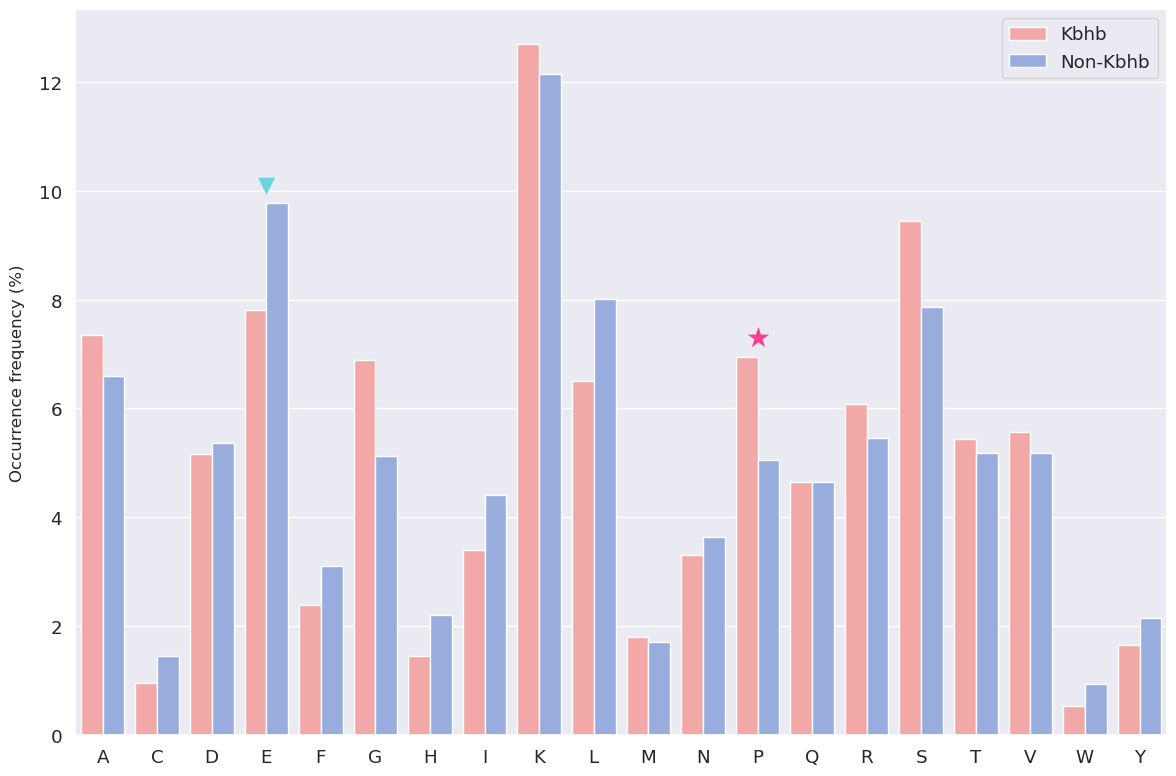

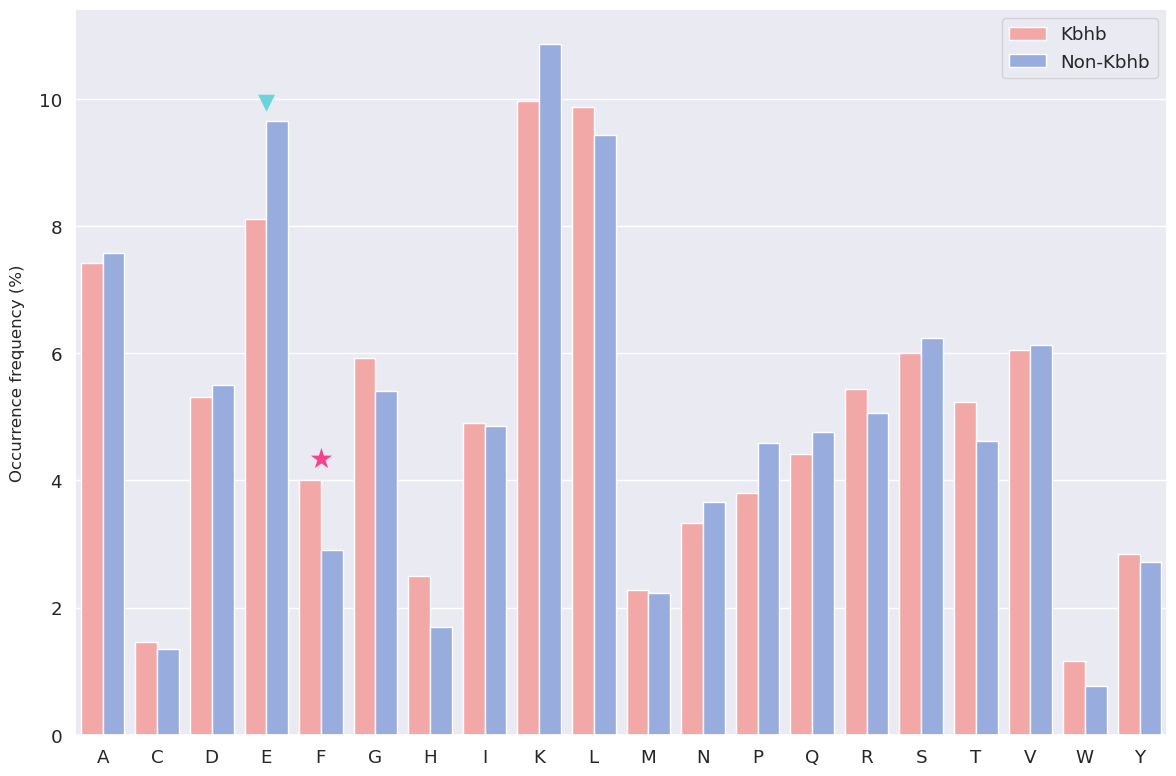

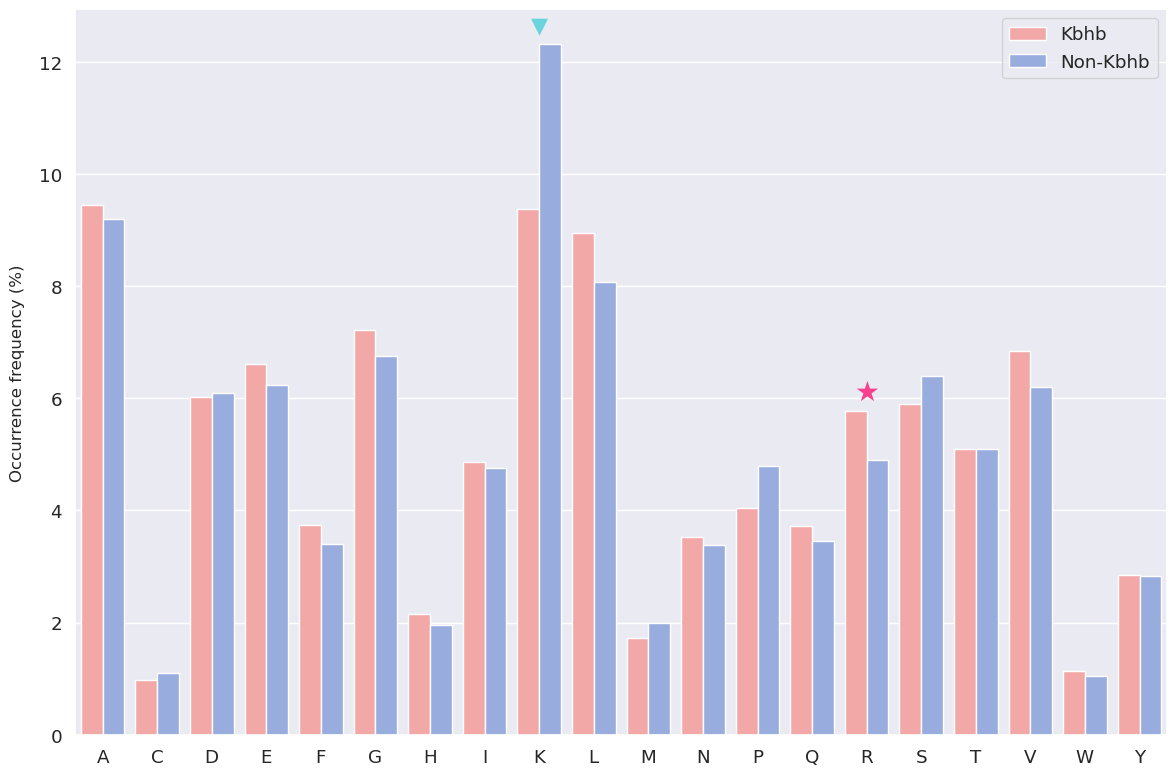

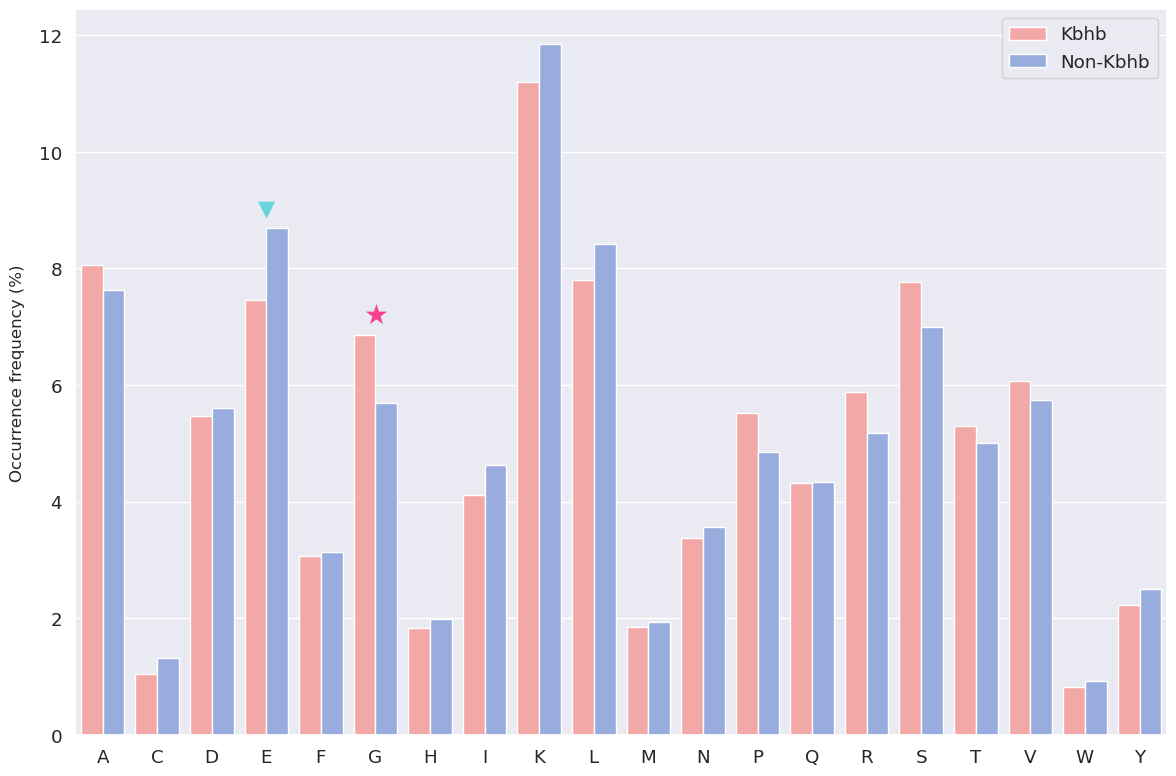

In [18]:
sp_distrition = {}
ratio = 1
for index, sp in enumerate(['human', 'mouse','false_smut','general']):# ['human', 'mouse','false_smut', 'mixed']:
    train_file = f'../Datasets/nr40/win51/{sp}_train_ratio_{ratio}.fa'
    test_file = f'../Datasets/nr40/win51/{sp}_test_ratio_{ratio}.fa'
    train_list = [[str(record.seq), float(record.id.replace('>','').split('|')[1])] for record in SeqIO.parse(train_file, "fasta")]
    test_list = [[str(record.seq), float(record.id.replace('>','').split('|')[1])] for record in SeqIO.parse(test_file, "fasta")]

    pos_train_list = [record[0] for record in train_list if record[1]==1.0]
    pos_test_list = [record[0] for record in train_list if record[1]==1.0]
    all_poslist = pos_train_list + pos_test_list
    neg_train_list = [record[0] for record in test_list if record[1]==0.0]
    neg_test_list = [record[0] for record in test_list if record[1]==0.0]
    # print(len(pos_train_list), len(pos_test_list), len(neg_train_list), len(neg_test_list))

    all_neglist = neg_train_list + neg_test_list
    pos_dict = distribution_aa(all_poslist, normalize=True)
    neg_dict = distribution_aa(all_neglist, normalize=True)
    sp_distrition[sp] = [pos_dict, neg_dict]
    draw_aa_distribution(sp_distrition[sp], f'Plots/{sp}_aa_distribution.svg')

## 1.2. Amino acid frequency

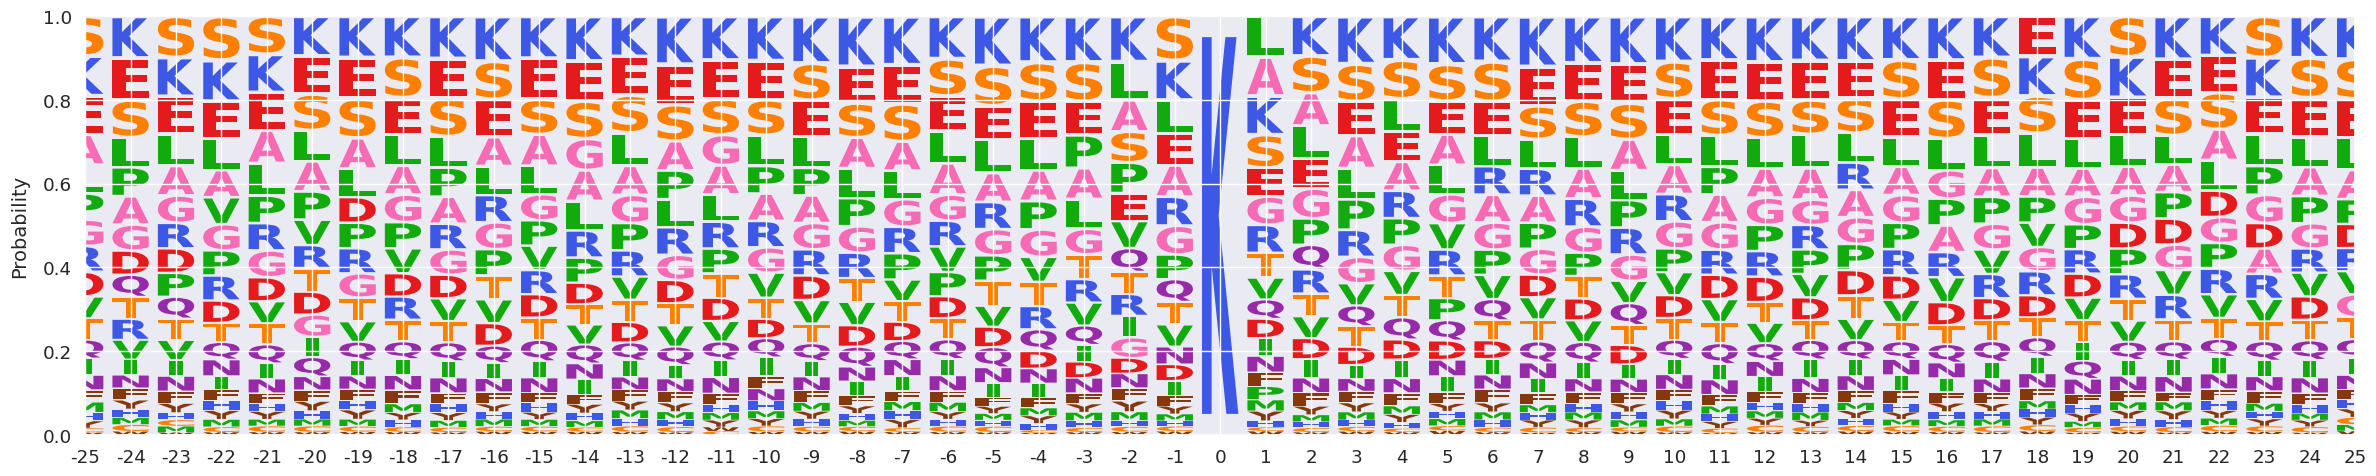

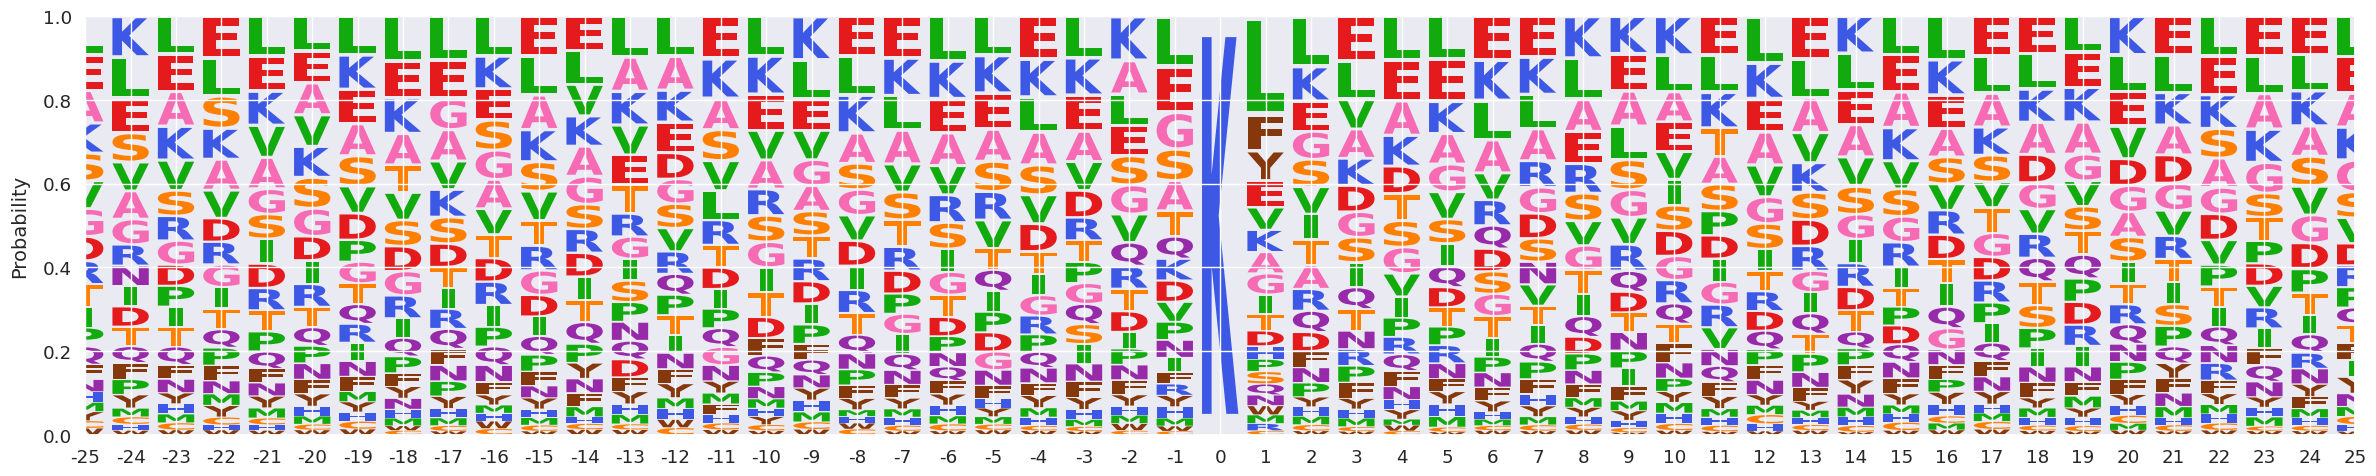

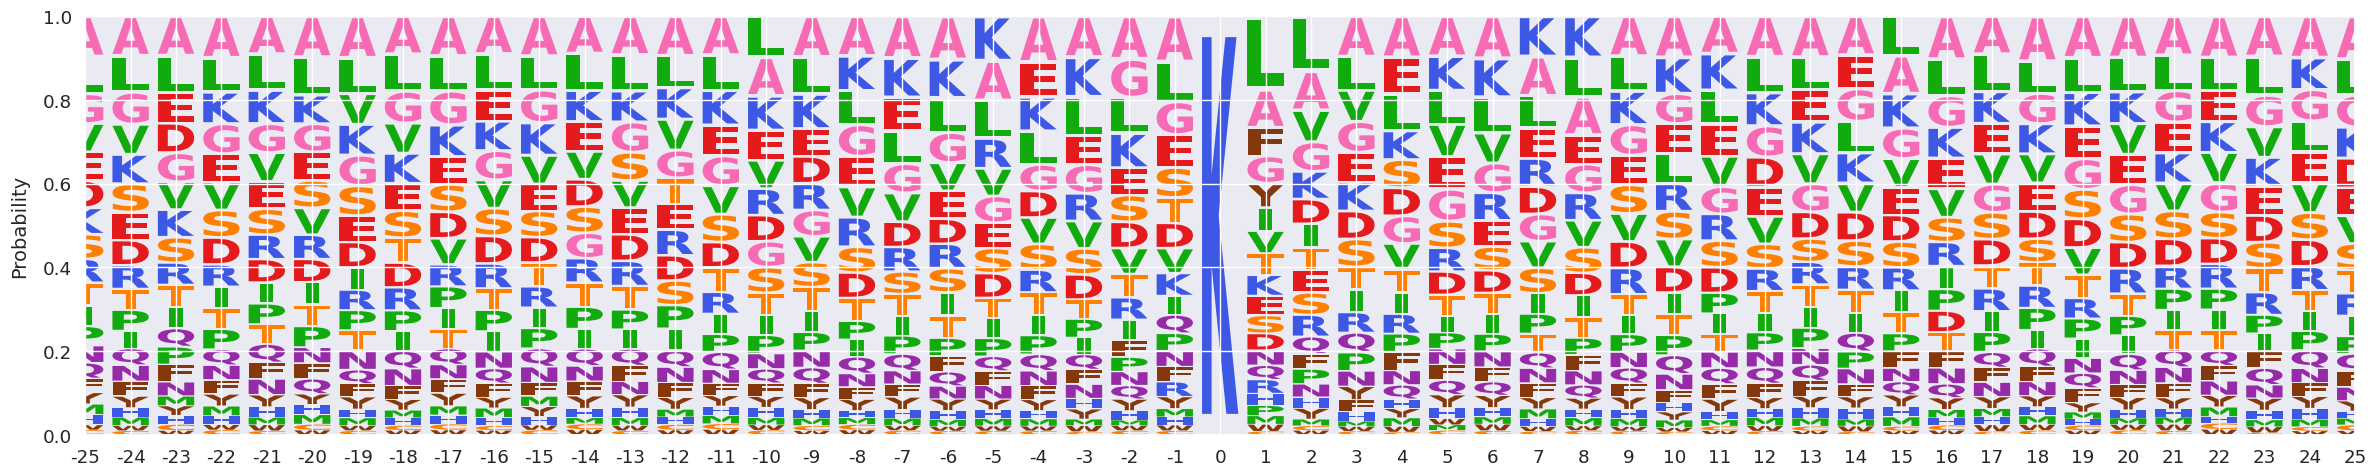

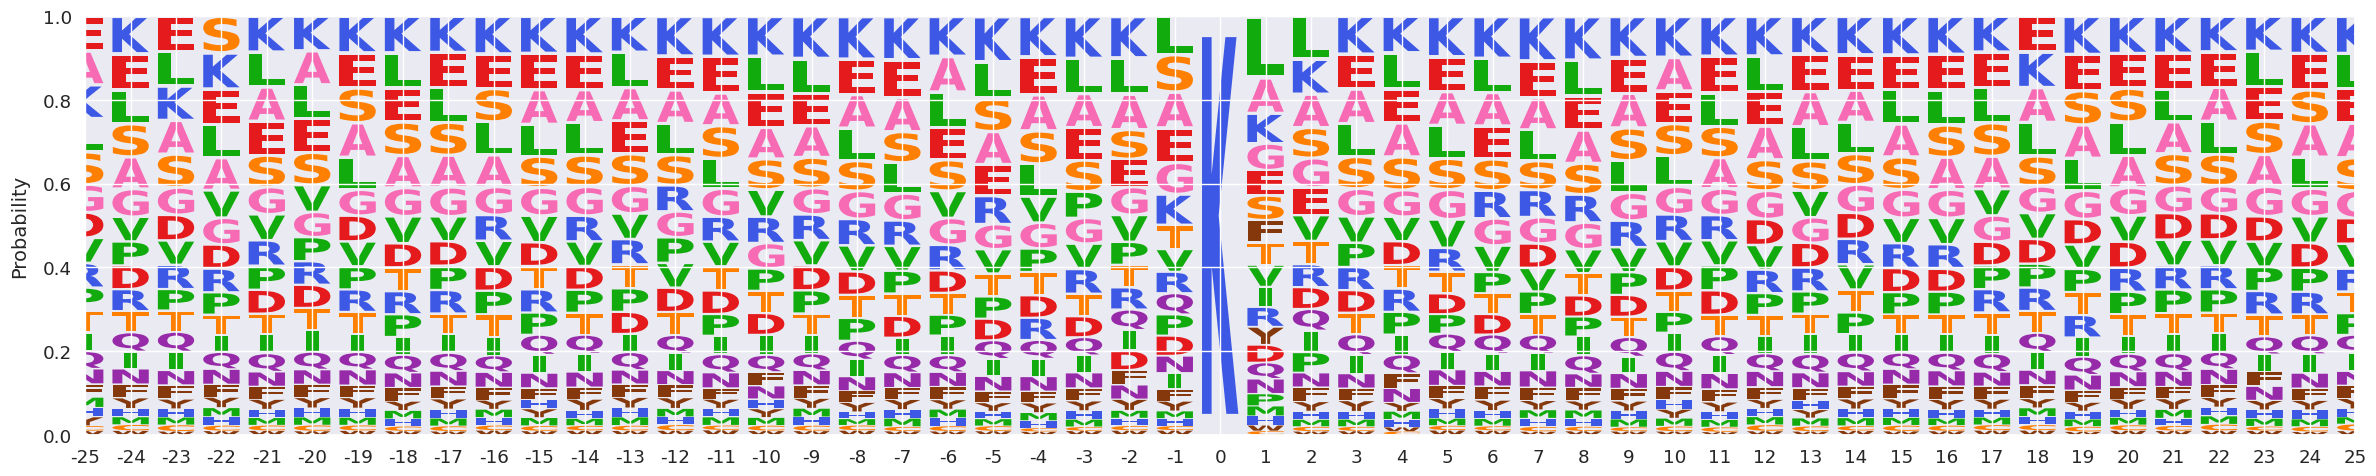

In [19]:
import logomaker
import matplotlib.pyplot as plt
import numpy as np
from Bio import AlignIO

def alntodf(aln, characters="ACDEFGHIKLMNPQRSTVWY"):
    alnRows = aln.get_alignment_length()
    compDict = {char:[0]*alnRows for char in characters}
    for record in aln:
        header = record.id
        seq = record.seq
        for aaPos in range(len(seq)):
            aa = seq[aaPos]
            if aa in characters:
                compDict[aa][aaPos] += 1    
    index = range(-25, 26)
    myd = pd.DataFrame(compDict, index=index)
    df = myd.div(myd.sum(axis=1), axis=0)
    return df

for index, sp in enumerate(['human', 'mouse','false_smut','general']):
    aln_f = f"../Datasets/nr40/win51/{sp}_ratio_1.fa"
    aln = AlignIO.read(aln_f, "fasta")
    fig, ax = plt.subplots(1,1, figsize=(24,5))
    df = alntodf(aln)
    ww_logo = logomaker.Logo(df,
                        ax=ax,
                        color_scheme='dmslogo_funcgroup',
                        vpad=.1,
                        width=.8)
    ax.set_xlim(-25, 25)
    ticks = np.arange(-25, 26, 1)
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ww_logo.ax.set_ylabel('Probability', fontsize=14, labelpad=10)
    fig.tight_layout()
    plt.savefig(f'Plots/{sp}_seqlogo.png', dpi=600)

# 2. Performance evaluation

In [100]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, roc_curve, auc, precision_recall_curve
def draw_tsne(test_labels, embedding, save_path, ptm_type='Kbhb'):
    from sklearn.manifold import TSNE
    X_embedded = TSNE(n_components=2).fit_transform(embedding)
    fig, ax = plt.subplots()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for val,color,ptm in [("0", '#03BECA',f'Non-{ptm_type} sites'), ("1", '#F77672',f'{ptm_type} sites')]:
        val = int(val)
        idx = np.where(test_labels == val)
        # idx = (test_labels == val).nonzero()
        plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1],s=4,alpha=0.6, c=color, label=ptm)
    plt.legend(loc='upper right',prop={ 'size': 10},scatterpoints=1)
    plt.savefig(save_path,dpi=600) 

# emd_list = ['raw_emd','fea_in','bert_emd','plm_out','cnn_out','lstm_out','attn_out','final_out']


def draw_performance_cm(dat, save_path, cmap=plt.cm.Purples):
    # dat = np.array([line[7] for line in result_list]).reshape(4,4)
    categories =  ['General','Human', 'Mouse','False_smut']
    # randomly generated array 
    figure = plt.figure() 
    axes = figure.add_subplot(111) 
    # using the matshow() function  
    caxes = axes.matshow(dat, interpolation ='nearest', cmap=cmap, origin ='lower') 
    # figure.colorbar(caxes,ticks=[0, 0.2, 0.4, 0.6, 0.8, 1]) 
    # cbar = figure.colorbar(caxes)
    cmap = ccc
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = figure.colorbar(im)
    cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    cbar.set_ticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])

    for i in range(len(dat)):
        for j in range(len(dat)):
            c = dat[i][j]
            if c > 0.001:
                plt.text(j, i, f"{c:.2f}", color='black', fontsize=10, va='center', ha='center')
                
    axes.set_xticklabels([' ']+categories, fontsize=12)
    axes.tick_params(axis='x', direction='out', pad=10)
    axes.set_yticklabels([' ']+categories, fontsize=12) 
    plt.ylabel('Models', fontsize=14, labelpad=10) # , fontweight='bold')
    plt.xlabel('Datasets', fontsize=14, labelpad=10) #, fontweight='bold')
    axes.xaxis.set_label_position('bottom') 
    axes.xaxis.tick_bottom()
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)


def draw_AUROC(data, save_path, splist=['Human', 'Mouse','False smut', 'General']):
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(6.4, 4.8), dpi=600)
    plt.title('Receiver Operating Characteristic', pad=20, fontsize=16)
    for ind, name in enumerate(splist):
        targets = data[ind][0]
        probs = data[ind][1]
        fpr, tpr, thresholds = roc_curve(y_true=targets,y_score=probs)
        if name in ['H. sapiens', 'M. musculus', 'U. virens']:
            name = rf'${name}$'  # 使用 LaTeX 格式将 name 设置为斜体
        plt.plot(fpr, tpr, label = f'{name}: AUROC = {auc(fpr, tpr):.4f}')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], '--', color='black')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate', fontsize=14, labelpad=10)
    plt.xlabel('False Positive Rate', fontsize=14, labelpad=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)

def draw_AUPRC(data, save_path, splist=['Human', 'Mouse','False smut', 'General']):
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(6.4, 4.8), dpi=600)
    plt.title('Precision Recall Curve', pad=20, fontsize=16)
    for ind, name in enumerate(splist):
        targets = data[ind][0]
        probs = data[ind][1]
        precision_1, recall_1, threshold_1 = precision_recall_curve(targets, probs)  # 计算Precision和Recall
        aupr_1 = auc(recall_1, precision_1)
        if name in ['H. sapiens', 'M. musculus', 'U. virens']:
            name = rf'${name}$'  # 使用 LaTeX 格式将 name 设置为斜体
        plt.plot(recall_1, precision_1, label = f'{name}: AUPRC = {aupr_1:.4f}')
    plt.legend(loc = 'lower left')
    plt.plot([1, 0],'--',color='black')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision', fontsize=14, labelpad=10)
    plt.xlabel('Recall', fontsize=14, labelpad=10)
    plt.tight_layout()
    plt.savefig(save_path, dpi=600)

def plot_confusion_matrix(cm, savepath, cmap=plt.cm.Blues, classes=['Non-Kbhb', 'Kbhb'], title='Confusion Matrix'):
    
    plt.figure(figsize=(6.4, 4.8), dpi=600)
    plt.grid(False)
    np.set_printoptions(precision=2)

    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.0f" % (c,), color='black', fontsize=15, va='center', ha='center')
            
#     norm = matplotlib.colors.Normalize(vmin=cm.min(), vmax=cm.max()*0.8)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18, pad=15)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90, fontsize=14)
    plt.yticks(xlocations, classes, fontsize=14)
    plt.ylabel('Actual label', fontsize=16, labelpad=10)
    plt.xlabel('Predict label', fontsize=16, labelpad=10)
    
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
#     plt.gcf().subplots_adjust(bottom=0.15)
    
    # show confusion matrix
    plt.savefig(savepath, dpi=600)

## 2.1. Predicting Kbhb on testing set

### Parameters for model and datasets

In [10]:
from SLAM_combine import *
gpu = 0
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')
n_layers = 1
dropout = 0.5
embedding_dim = 32
hidden_dim = 64
out_dim = 32

node_dim = 267
edge_dim = 632
nneighbor = 32
atom_type = 'CA' # CB, R, C, N, O
gnn_layers = 5
pdb_dir = 'Datasets/Structure/PDB'

encoder_list = ['cnn','lstm','fea', 'gnn', 'plm']
pretrained_model = '/mnt/data/zhqin/pretrain_LM/prot_bert/'
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, do_lower_case=False, use_fast=False)

if 'plm' in encoder_list:
    BERT_encoder = AutoModel.from_pretrained(pretrained_model, local_files_only=True, output_attentions=False).to(device)
else:
    BERT_encoder = None
if 'bert' in pretrained_model:
    PLM_dim = 1024
elif 'esm' in pretrained_model:
    PLM_dim = 1280
if 'fea' in encoder_list:
    manual_fea = [BLOSUM62, BINA]
    fea_dim = 41
else:
    manual_fea=None
    fea_dim = None

Some weights of the model checkpoint at /mnt/data/zhqin/pretrain_LM/prot_bert/ were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
dataset_list = []
for sp_pred in ['general', 'human', 'mouse', 'false_smut']:
    project = f'{sp_model}_struct_plm'
    root_dir = f'result/SLAM_combine/{project}'
    logits_file = osp.join(root_dir, 'logits_results.txt')
    loss_file = osp.join(root_dir, 'all_train_step_loss.txt')
    best_auc_file = osp.join(root_dir, 'best_result.csv')
    epoch_result_file = osp.join(root_dir, 'epoch_result.csv')
    best_result = pd.read_csv(best_auc_file, sep='\t')
    epoch_result = pd.read_csv(epoch_result_file, sep='\t')
    best_epoch = best_result['Epoch'].item() # epoch_result.loc[epoch_result['AUROC'].idxmax()]['Epoch'].item()
    model_file = f'Models/SLAM_combine/{sp_model}_struct_plm/best_{sp_model}_struct_model_epoch.pt'
    print(model_file, f'for {sp_model} to predict {sp_pred}-specific datasets.')
    test_file = f'Datasets/nr40/win51/{sp_pred}_test_ratio_1.fa'
    test_ds = SLAMDataset(test_file, tokenizer, pdb_dir=pdb_dir, feature=manual_fea, nneighbor=nneighbor, atom_type=atom_type)
    dataset_list.append(test_ds)

Models/SLAM_combine/general_struct_plm/best_general_struct_model_epoch.pt for general to predict general-specific datasets.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2416/2416 [02:31<00:00, 16.00it/s]


Models/SLAM_combine/general_struct_plm/best_general_struct_model_epoch.pt for general to predict human-specific datasets.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [01:12<00:00, 14.51it/s]


Models/SLAM_combine/general_struct_plm/best_general_struct_model_epoch.pt for general to predict mouse-specific datasets.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 654/654 [00:42<00:00, 15.49it/s]


Models/SLAM_combine/general_struct_plm/best_general_struct_model_epoch.pt for general to predict false_smut-specific datasets.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [00:36<00:00, 19.67it/s]


In [103]:
from SLAM_combine import SLAMNet
from collections import defaultdict
plot_dir = 'Plots/performance'
os.makedirs(plot_dir, exist_ok=True)
results_list = []
species_embedding = {}
splist = ['general', 'human', 'mouse', 'false_smut']
for (ind, test_ds) in enumerate(dataset_list):
    sp_pred = splist[ind]
    window_size = test_ds.win_size
    valid_loader = DataLoader(test_ds,batch_size=128,shuffle=False,num_workers=8, collate_fn=graph_collate_fn, prefetch_factor=2)
    for sp_model in ['general', 'human', 'mouse', 'false_smut']:
        project = f'{sp_model}_struct_plm'
        root_dir = f'result/SLAM_combine/{project}'
        logits_file = osp.join(root_dir, 'logits_results.txt')
        loss_file = osp.join(root_dir, 'all_train_step_loss.txt')
        best_auc_file = osp.join(root_dir, 'best_result.csv')
        epoch_result_file = osp.join(root_dir, 'epoch_result.csv')
        best_result = pd.read_csv(best_auc_file, sep='\t')
        epoch_result = pd.read_csv(epoch_result_file, sep='\t')
        best_epoch = best_result['Epoch'].item() # epoch_result.loc[epoch_result['AUROC'].idxmax()]['Epoch'].item()
        model_file = f'Models/SLAM_combine/{sp_model}_struct_plm/best_{sp_model}_struct_plm_model_epoch.pt'
        print(model_file, f'for {sp_model} to predict {sp_pred}-specific datasets.')     
        model = SLAMNet(BERT_encoder=BERT_encoder, vocab_size=tokenizer.vocab_size, encoder_list=encoder_list,PLM_dim=PLM_dim,win_size=window_size,embedding_dim=embedding_dim, fea_dim=fea_dim, hidden_dim=hidden_dim, out_dim=out_dim,node_dim=node_dim, edge_dim=edge_dim, gnn_layers=gnn_layers,n_layers=n_layers,dropout=dropout).to(device)
        criterion = torch.nn.BCELoss().to(device)
        model.load_state_dict(torch.load(model_file))
        model.eval()
        valid_step = 0
        test_probs = []
        test_targets = []
        valid_total_loss = 0
        valid_total_acc = 0
        emd_dict = defaultdict(list)
        desc=['Model', 'Dataset', 'Acc', 'th','Rec/Sn', 'Pre', 'F1', 'Spe', 'MCC', 'AUROC', 'AUPRC', 'TN', 'FP', 'FN', 'TP']
        start = time.perf_counter()
        for ind,(data) in enumerate(valid_loader):
            g, input_ids, attention_mask, feature, label = data
            feature = feature.to(device)
            g = g.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label = label.to(device)
            pred = model(input_ids=input_ids, attention_mask=attention_mask, feature=feature, g_data=g)
            logits = pred.squeeze()
            loss = criterion(logits, label.float())
            acc = (logits.round() == label).float().mean()
            # print(f"Valid step:{valid_step} | Loss:{loss.item():.4f} | Acc:{acc:.4f}")
            valid_total_loss += loss.item()
            valid_total_acc += acc.item()
            test_probs.extend(logits.cpu().detach().numpy())
            test_targets.extend(label.cpu().detach().numpy())
            emd_dict[ind] = model.model_emd
            for key, value in model.model_emd.items():
                emd_dict[key].append(value) 
            valid_step += 1
        avg_loss = valid_total_loss / len(valid_loader)
        avg_acc = valid_total_acc / len(valid_loader)
        end = time.perf_counter()
        print(f"Test | {(end - start):.4f}s | Test loss: {avg_loss:.6f}| Test acc: {avg_acc:.4f}")
        test_probs = np.array(test_probs)
        test_targets = np.array(test_targets)
        acc_, th_, rec_, pre_, f1_, spe_, mcc_, auc_, pred_class, auprc_, tn, fp, fn, tp = eval_metrics(test_probs, test_targets)
        result_info = [sp_model, sp_pred, (tn+tp)/(tn+tp+fp+fn), th_, rec_, pre_, f1_, spe_, mcc_, auc_, auprc_, tn, fp, fn, tp]
        print_results(result_info, desc)
        results_list.append(result_info)
        if sp_model == sp_pred:
            species_embedding[sp_model] = emd_dict
            species_embedding[sp_model]['test_targets'] = test_targets
            species_embedding[sp_model]['test_logits'] = test_targets

Models/SLAM_combine/general_struct_plm/best_general_struct_plm_model_epoch.pt for general to predict general-specific datasets.
Test | 8.6051s | Test loss: 0.441512| Test acc: 0.7983
Model	Dataset	Acc	th	Rec/Sn	Pre	F1	Spe	MCC	AUROC	AUPRC	TN	FP	FN	TP
general	general	0.799	0.490	0.803	0.796	0.800	0.795	0.598	0.876	0.849	960	248	238	970
Models/SLAM_combine/human_struct_plm/best_human_struct_plm_model_epoch.pt for human to predict general-specific datasets.
Test | 8.4944s | Test loss: 0.657159| Test acc: 0.6880
Model	Dataset	Acc	th	Rec/Sn	Pre	F1	Spe	MCC	AUROC	AUPRC	TN	FP	FN	TP
human	general	0.695	0.400	0.708	0.691	0.699	0.683	0.391	0.757	0.751	825	383	353	855
Models/SLAM_combine/mouse_struct_plm/best_mouse_struct_plm_model_epoch.pt for mouse to predict general-specific datasets.
Test | 8.6472s | Test loss: 0.947190| Test acc: 0.6477
Model	Dataset	Acc	th	Rec/Sn	Pre	F1	Spe	MCC	AUROC	AUPRC	TN	FP	FN	TP
mouse	general	0.640	0.760	0.445	0.730	0.553	0.835	0.305	0.691	0.692	1009	199	670	538
Models/

In [317]:
g.batch

tensor([ 0,  0,  0,  ..., 71, 71, 71], device='cuda:0')

## 2.2. Draw AUROC and AUPRC curves

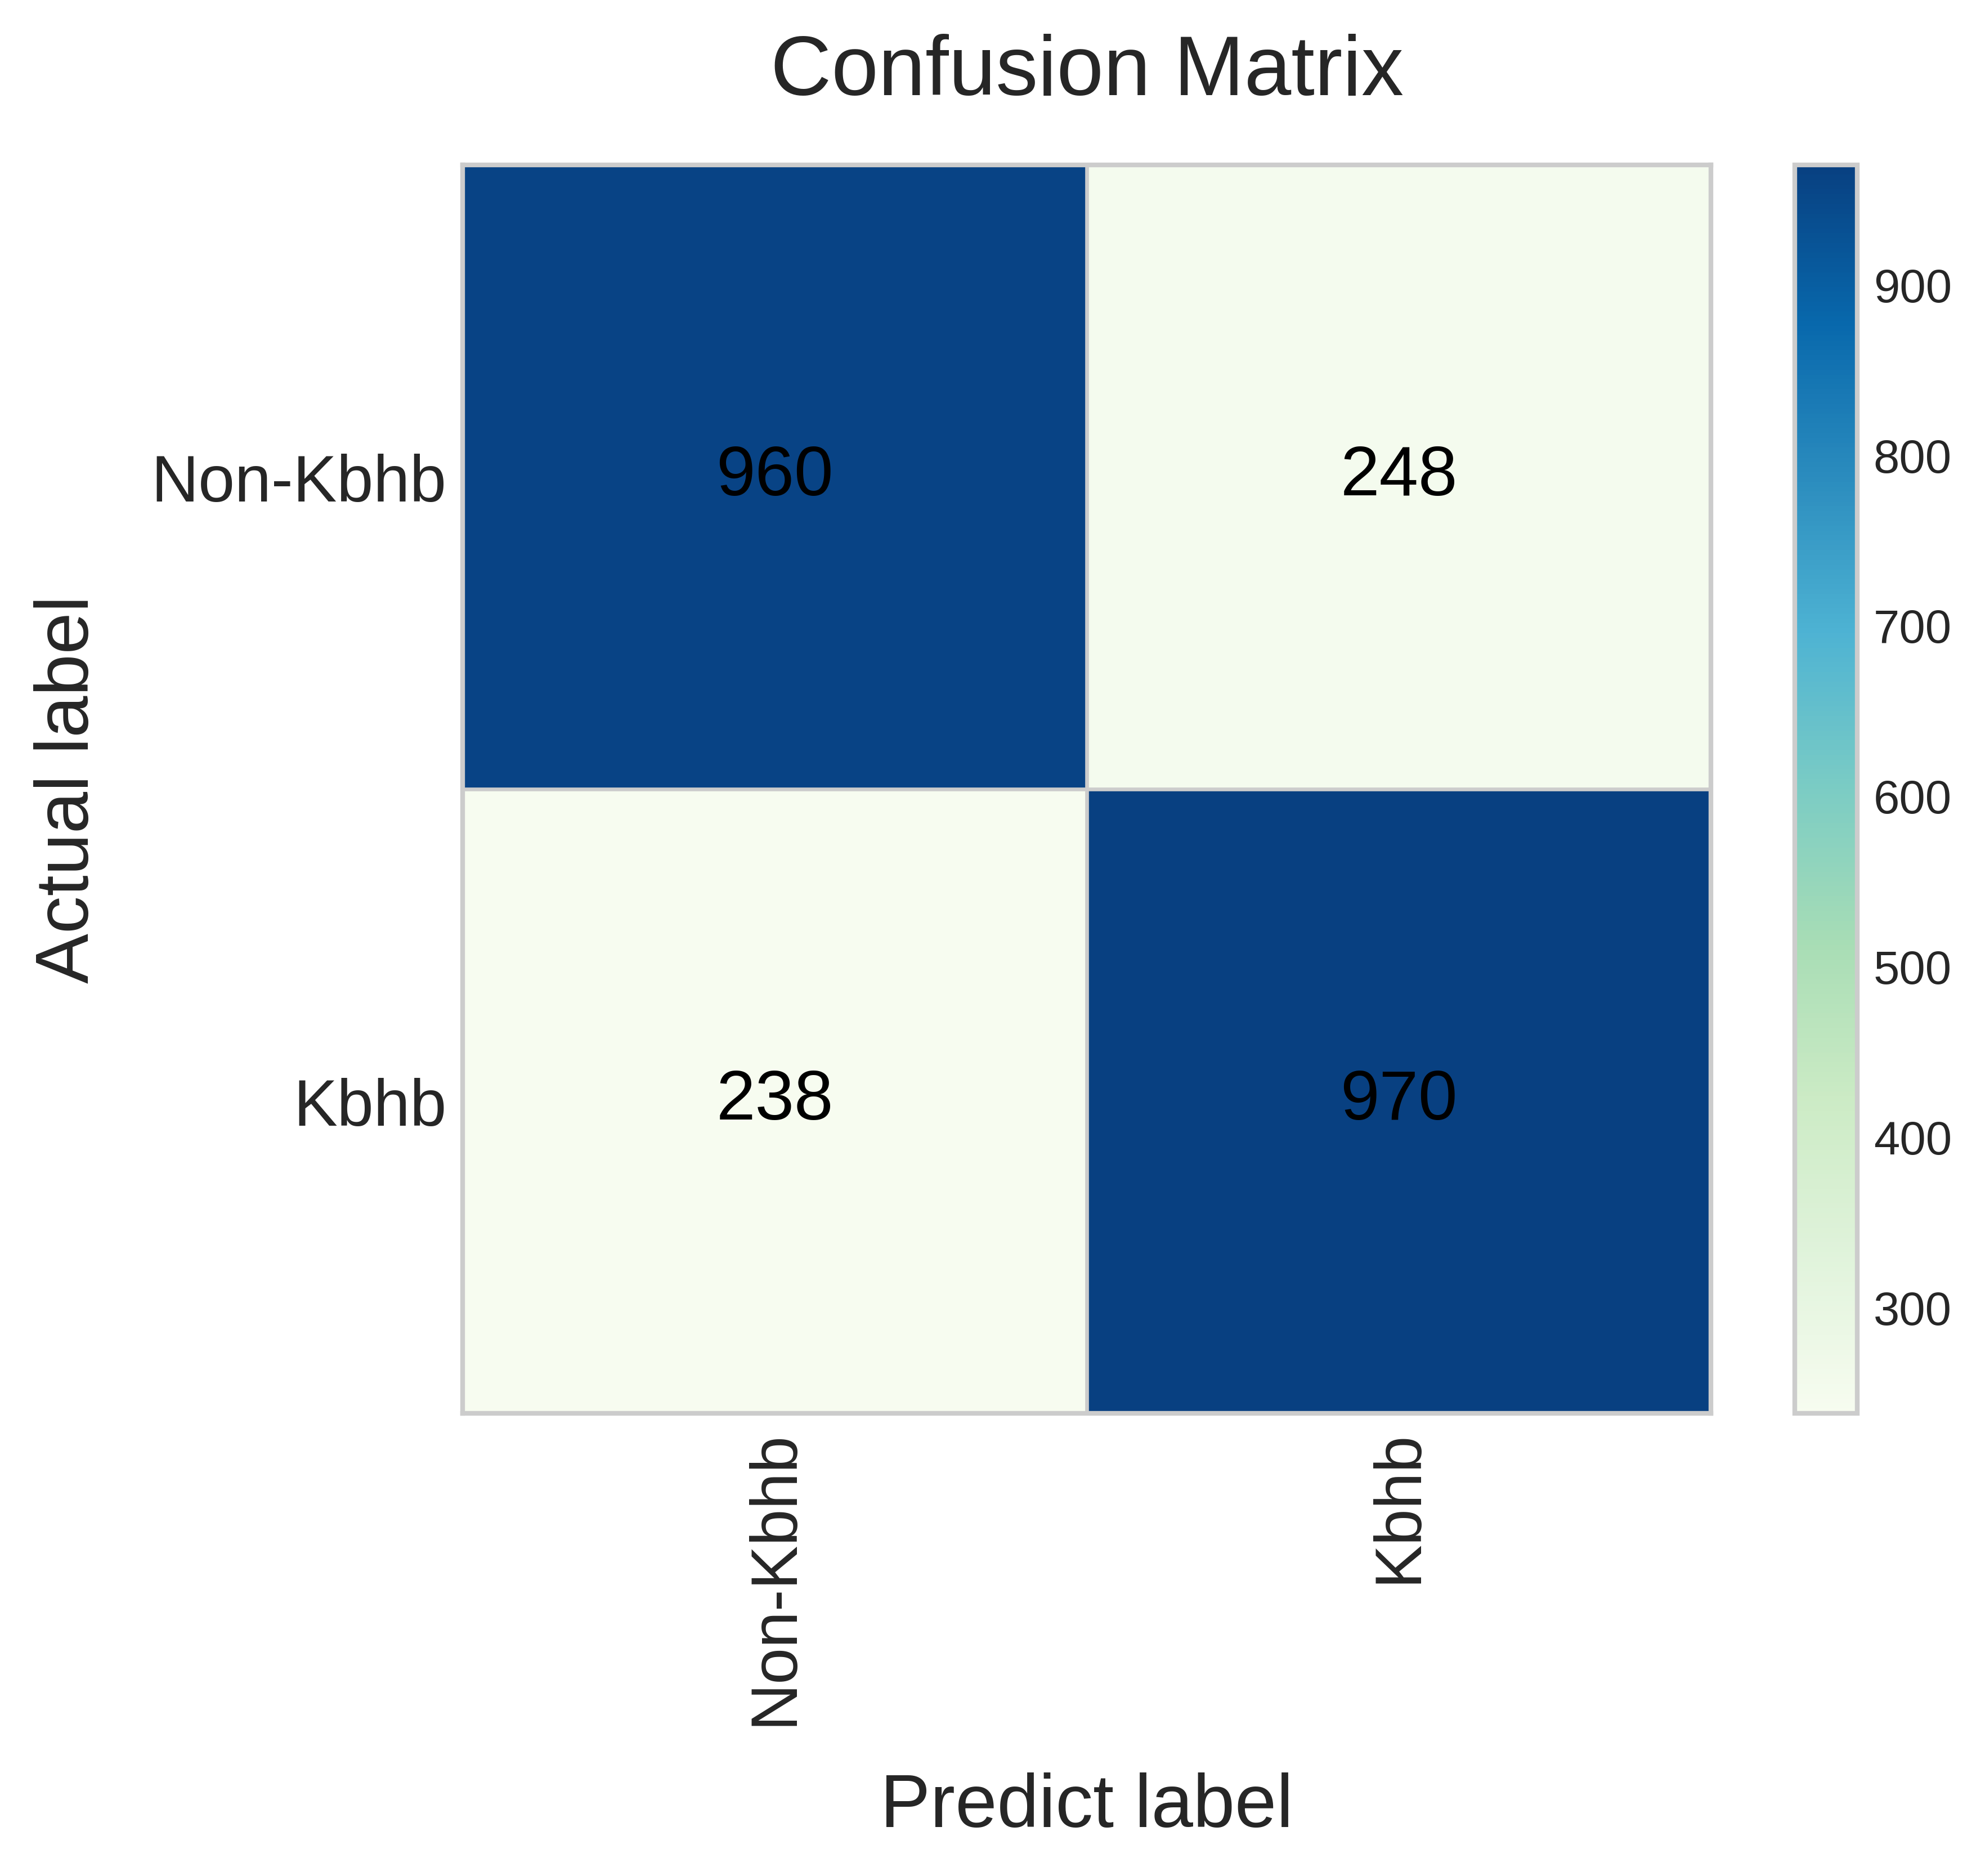

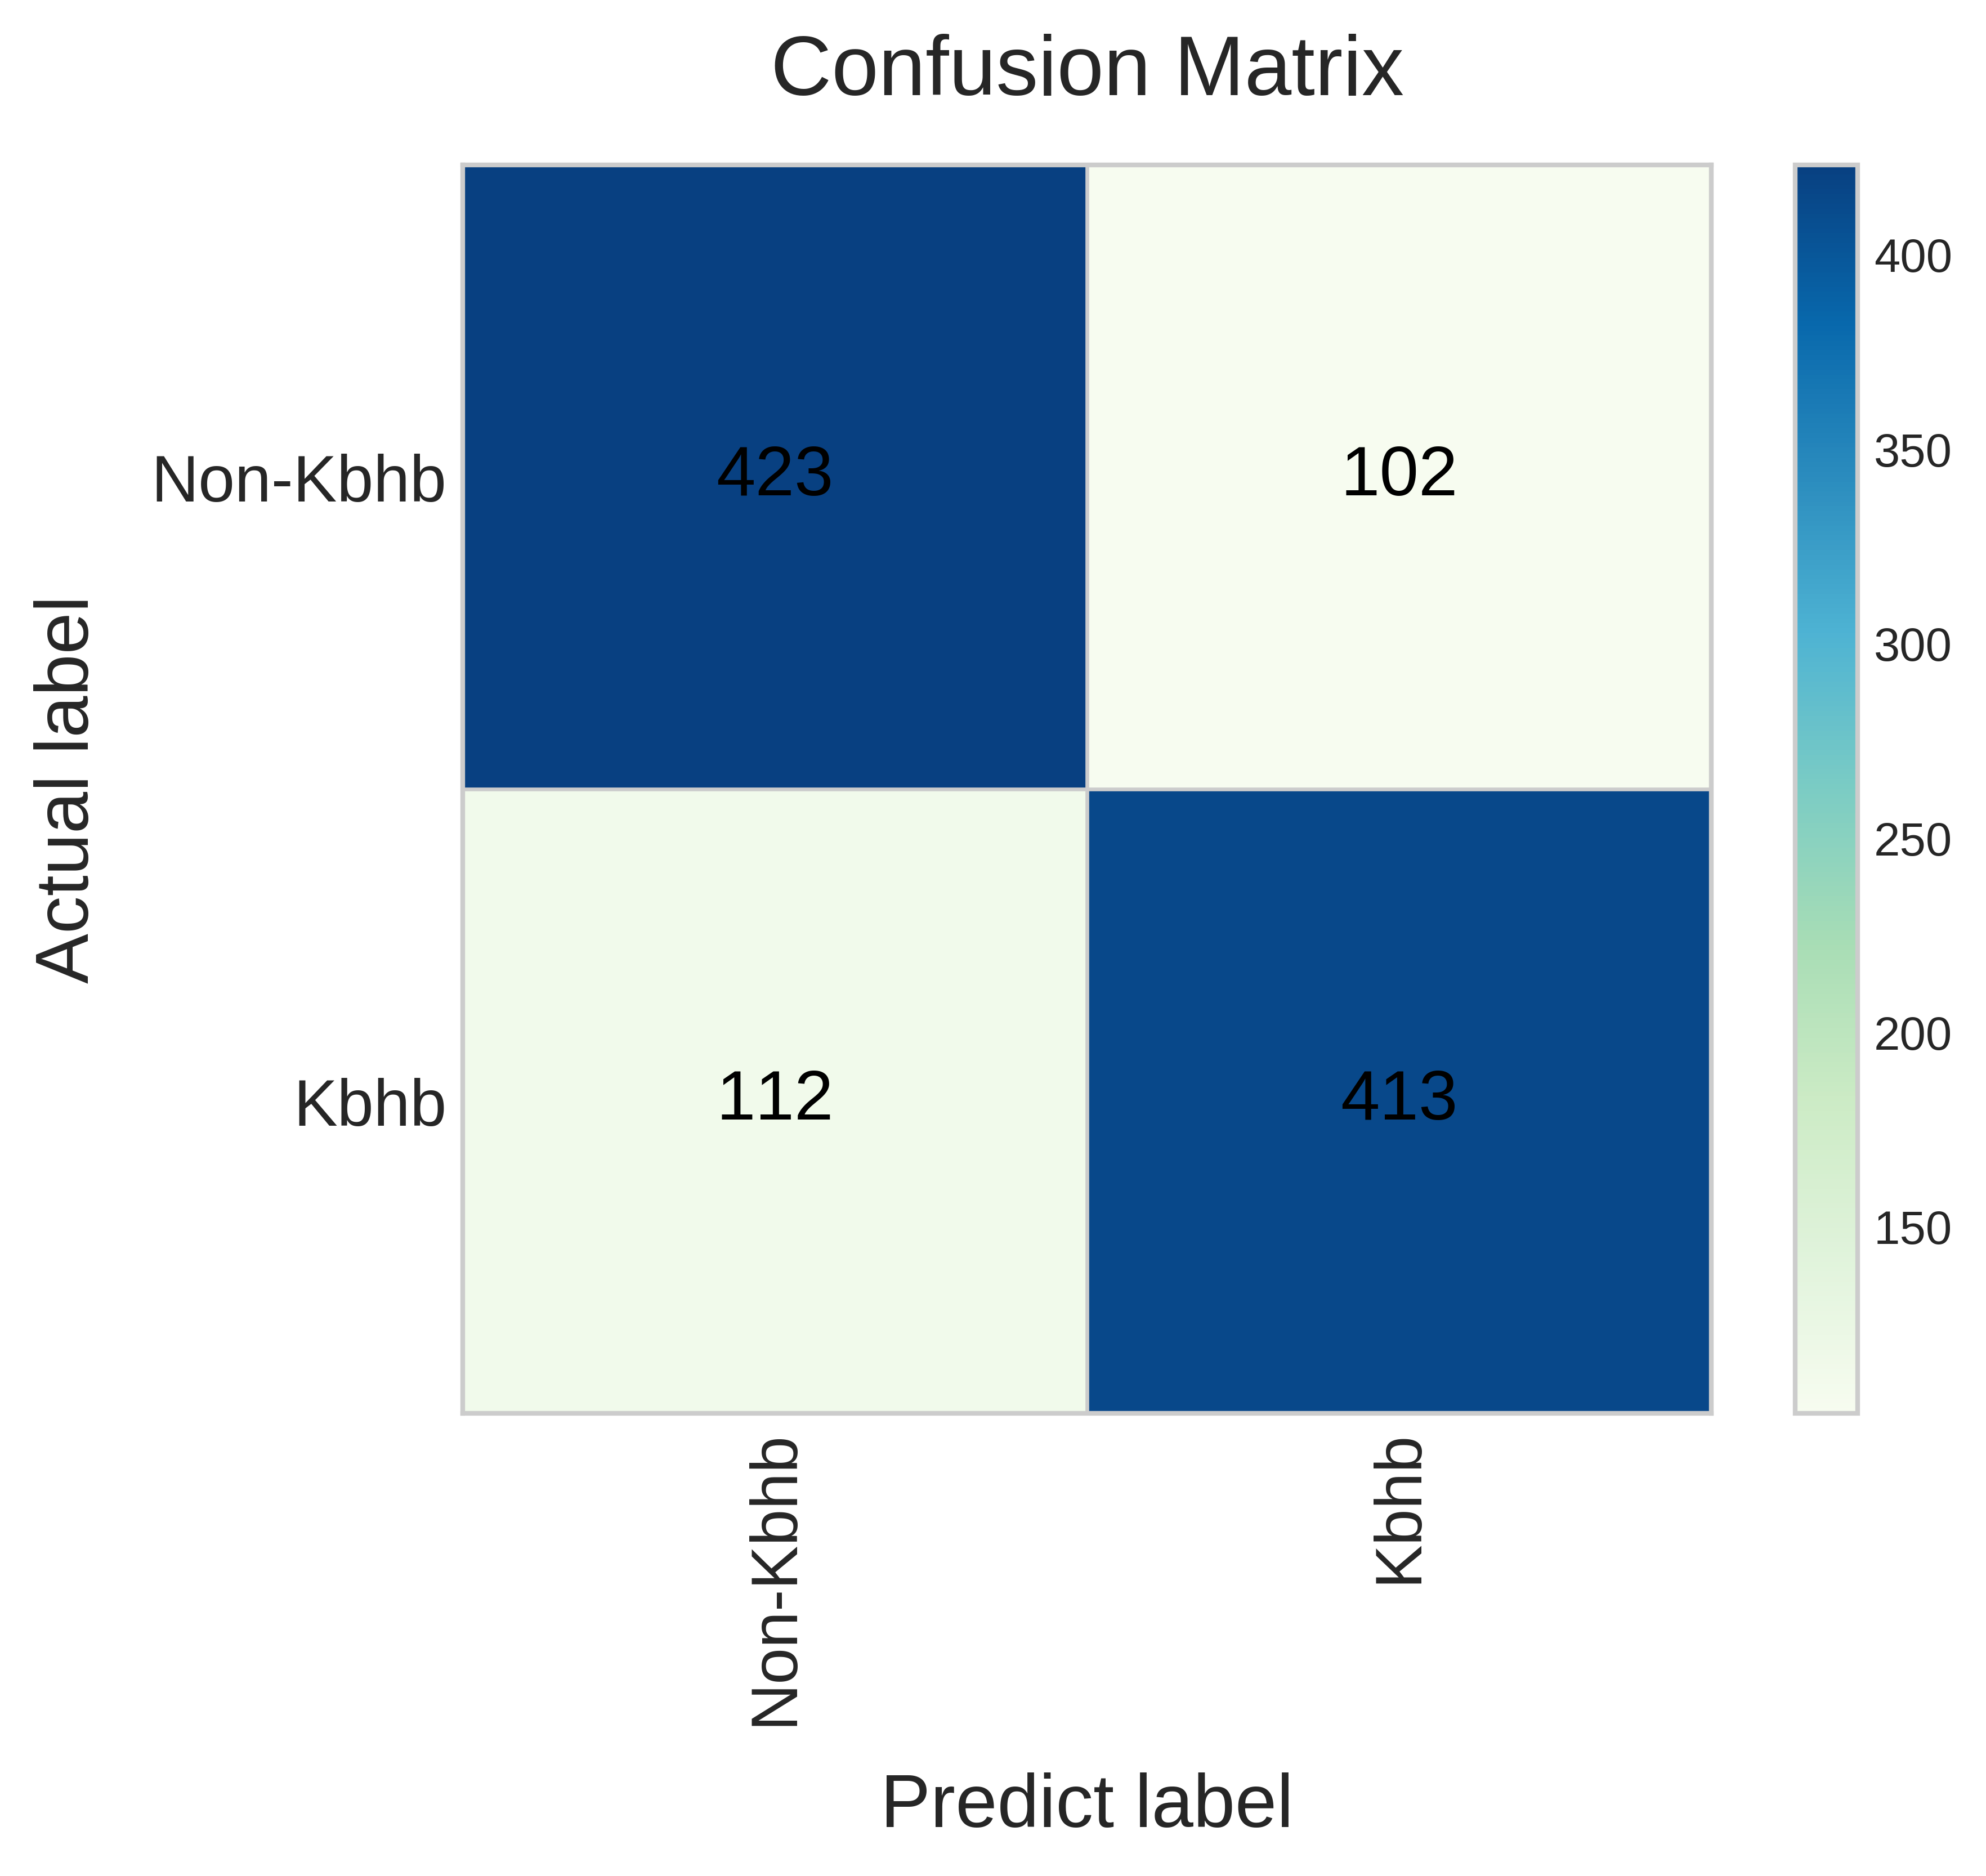

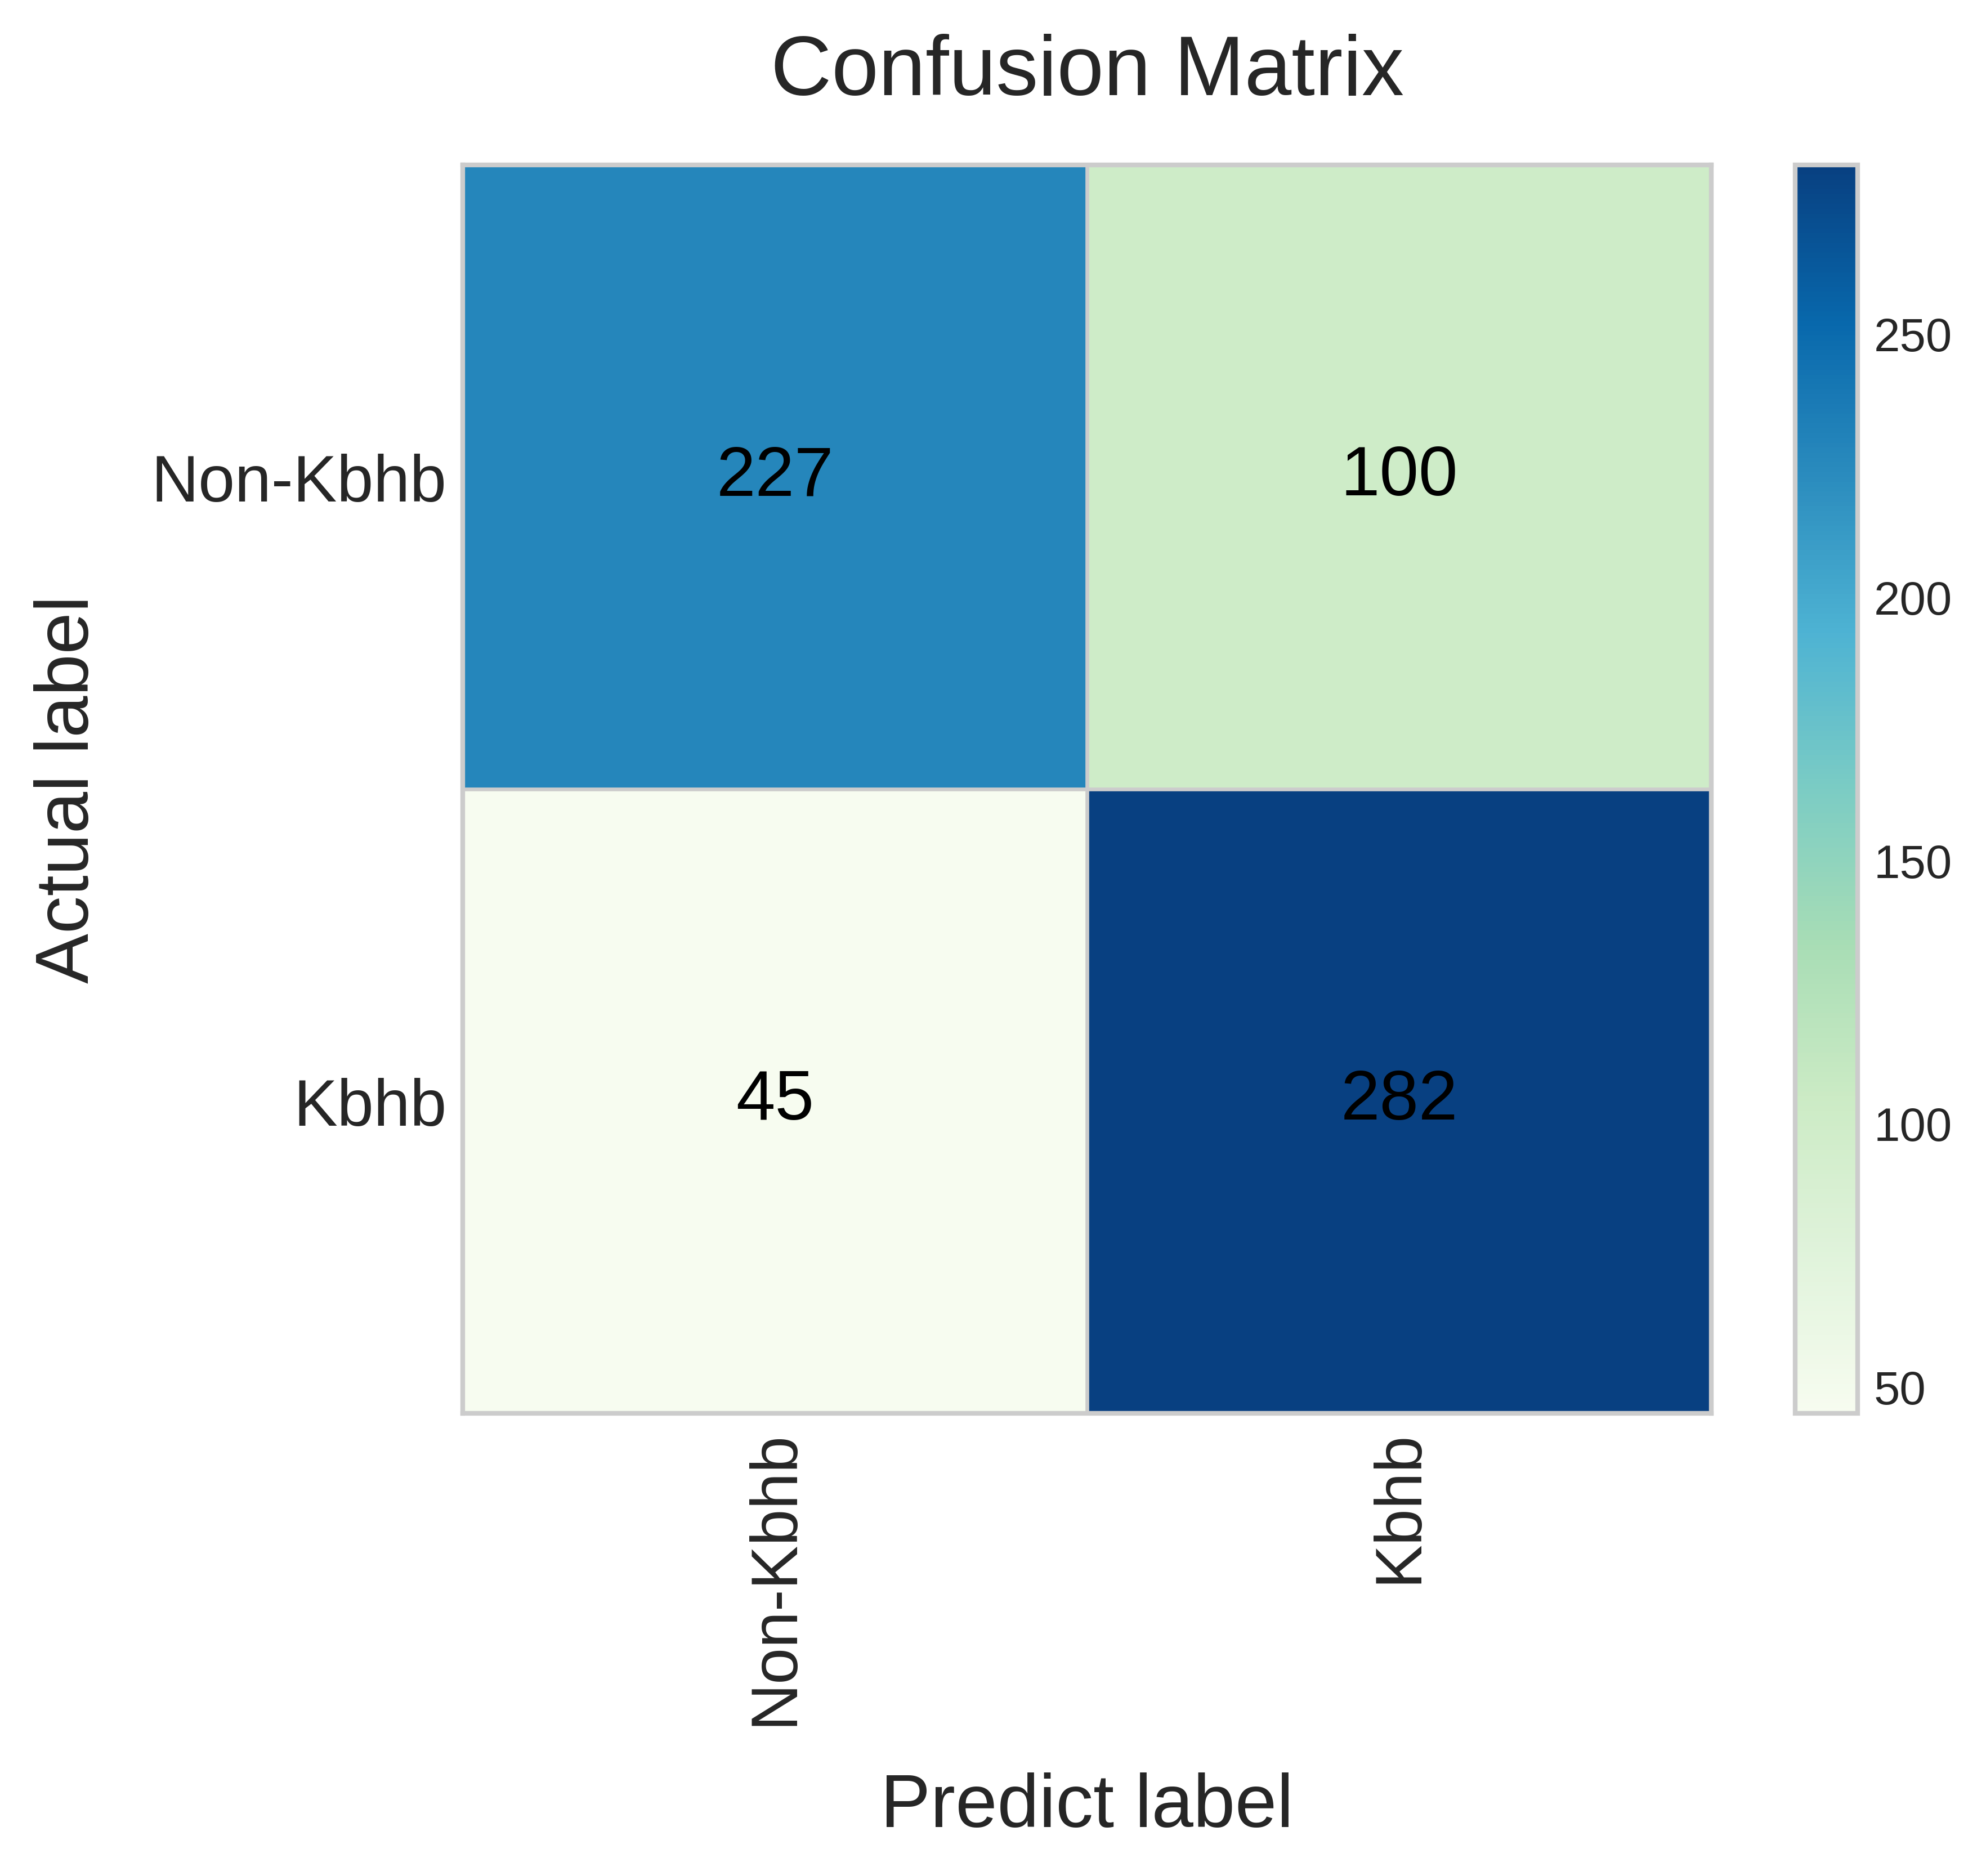

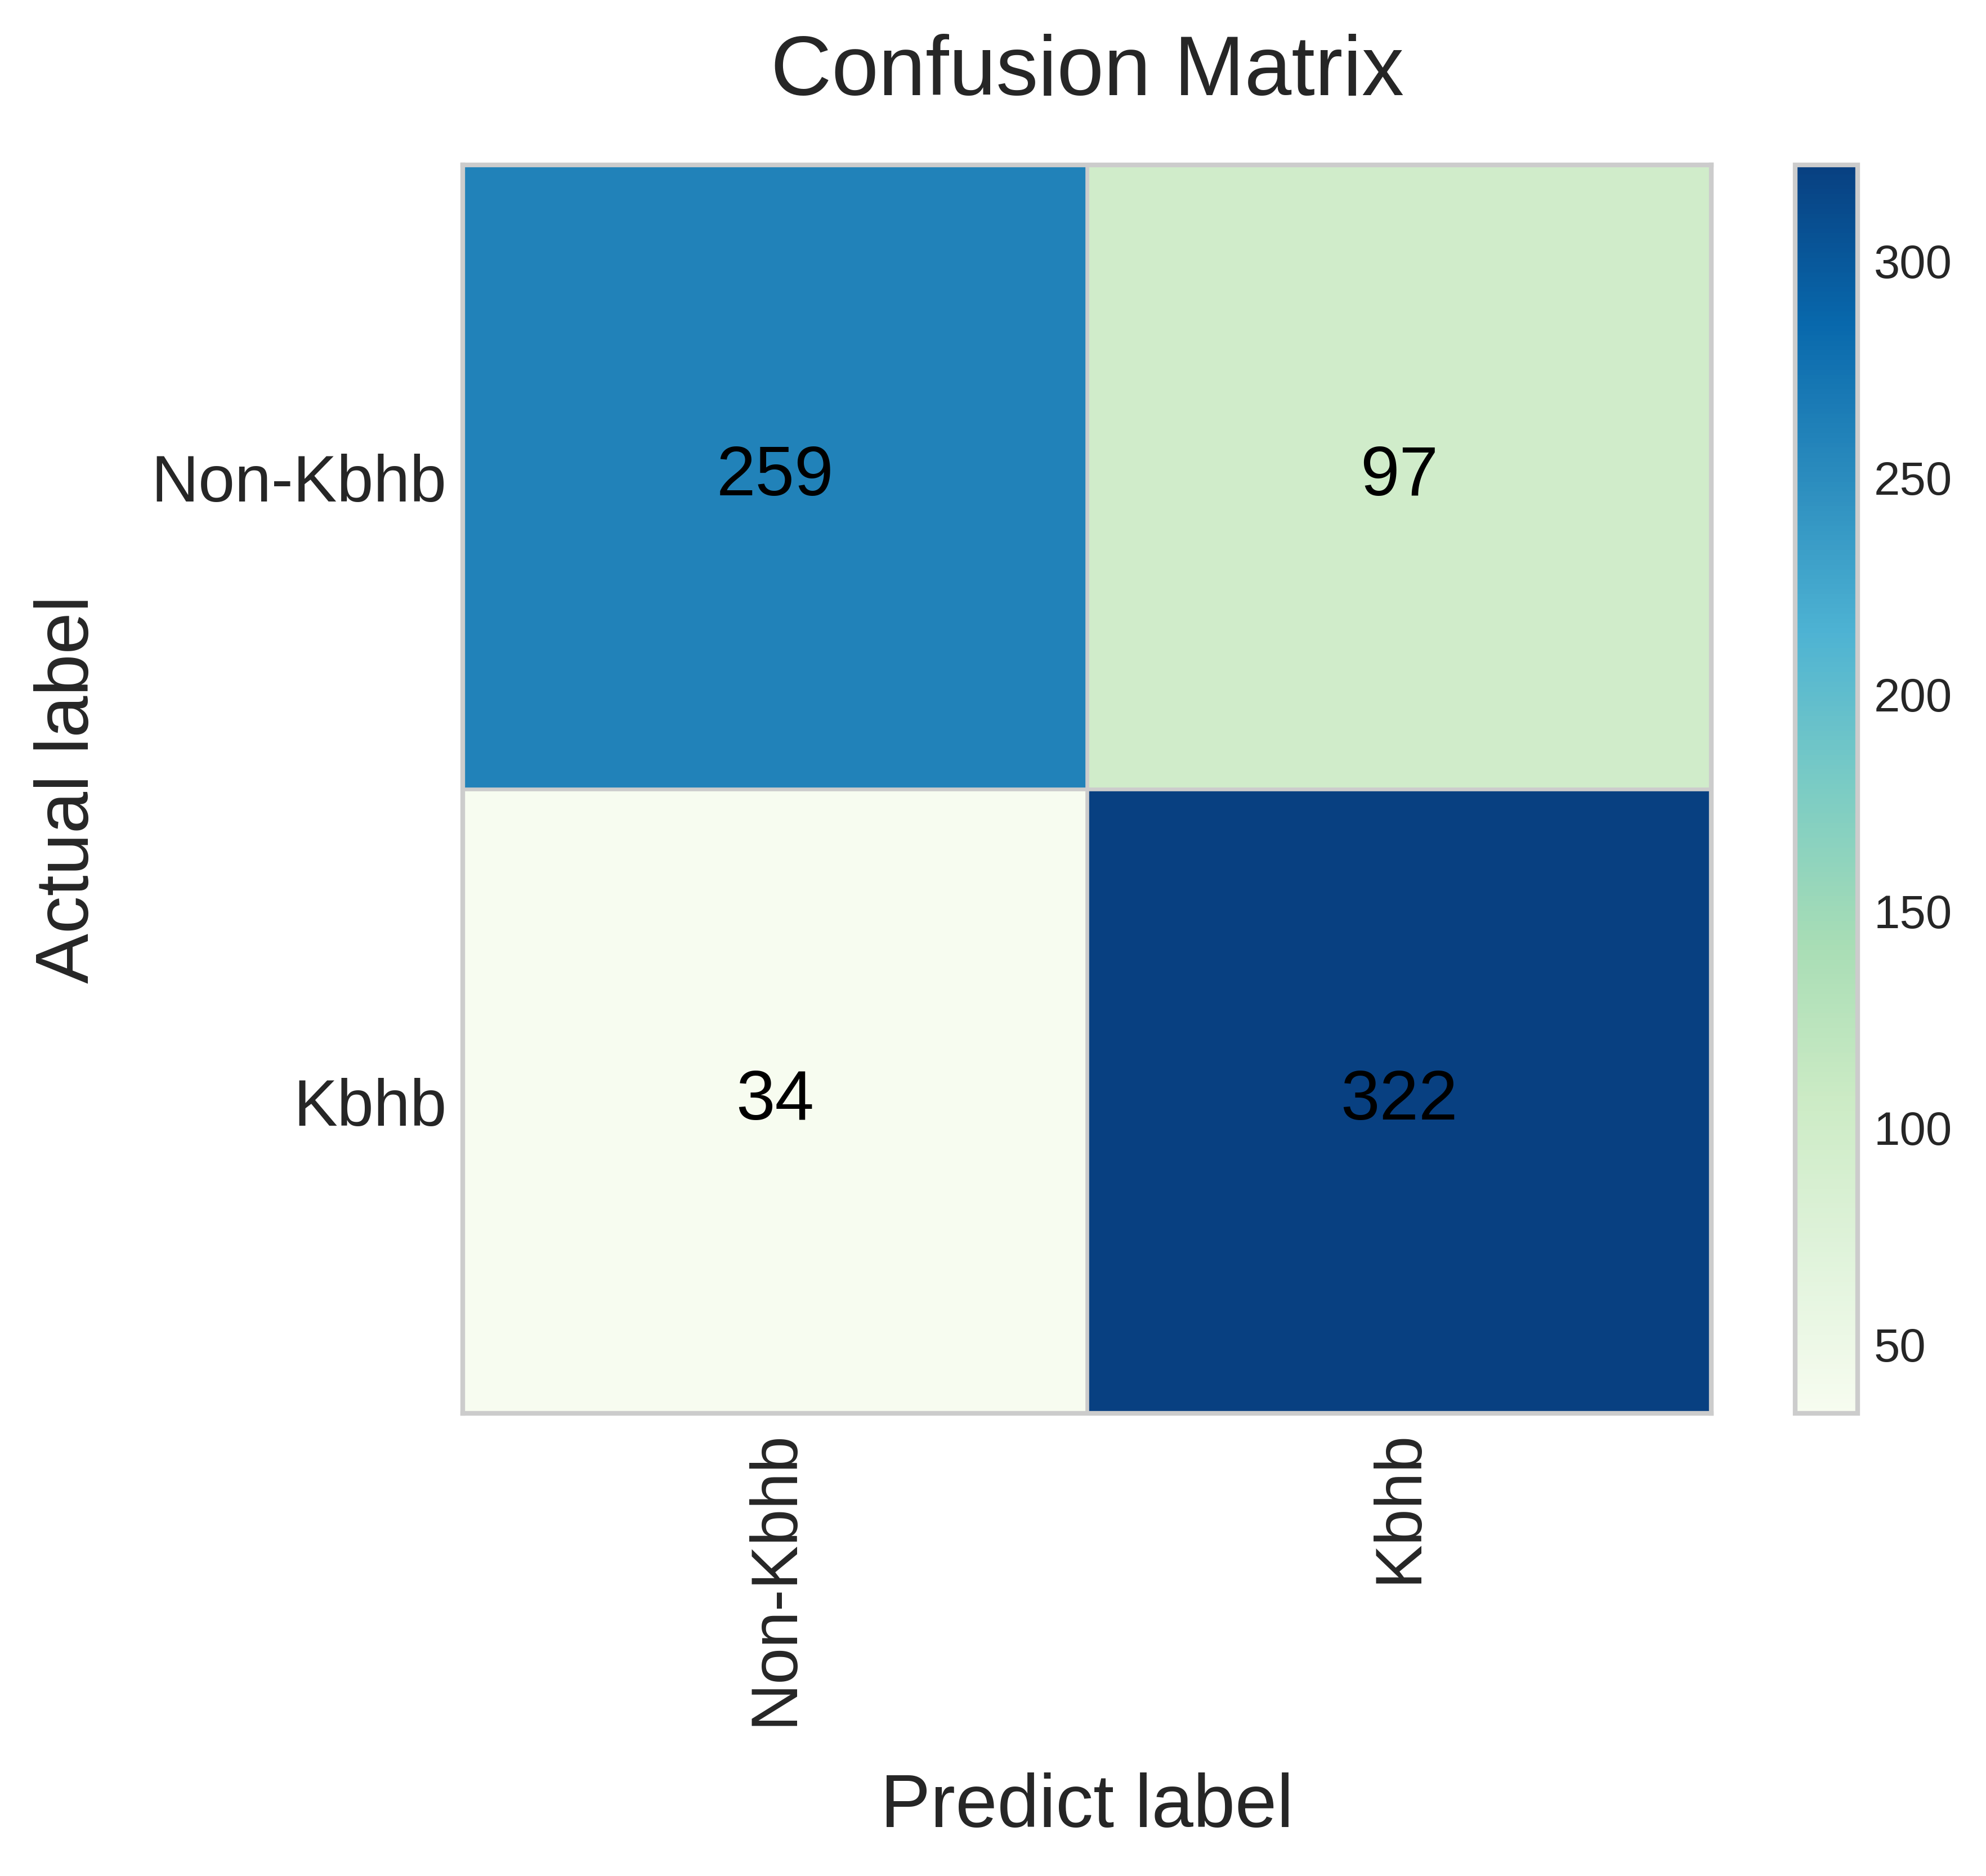

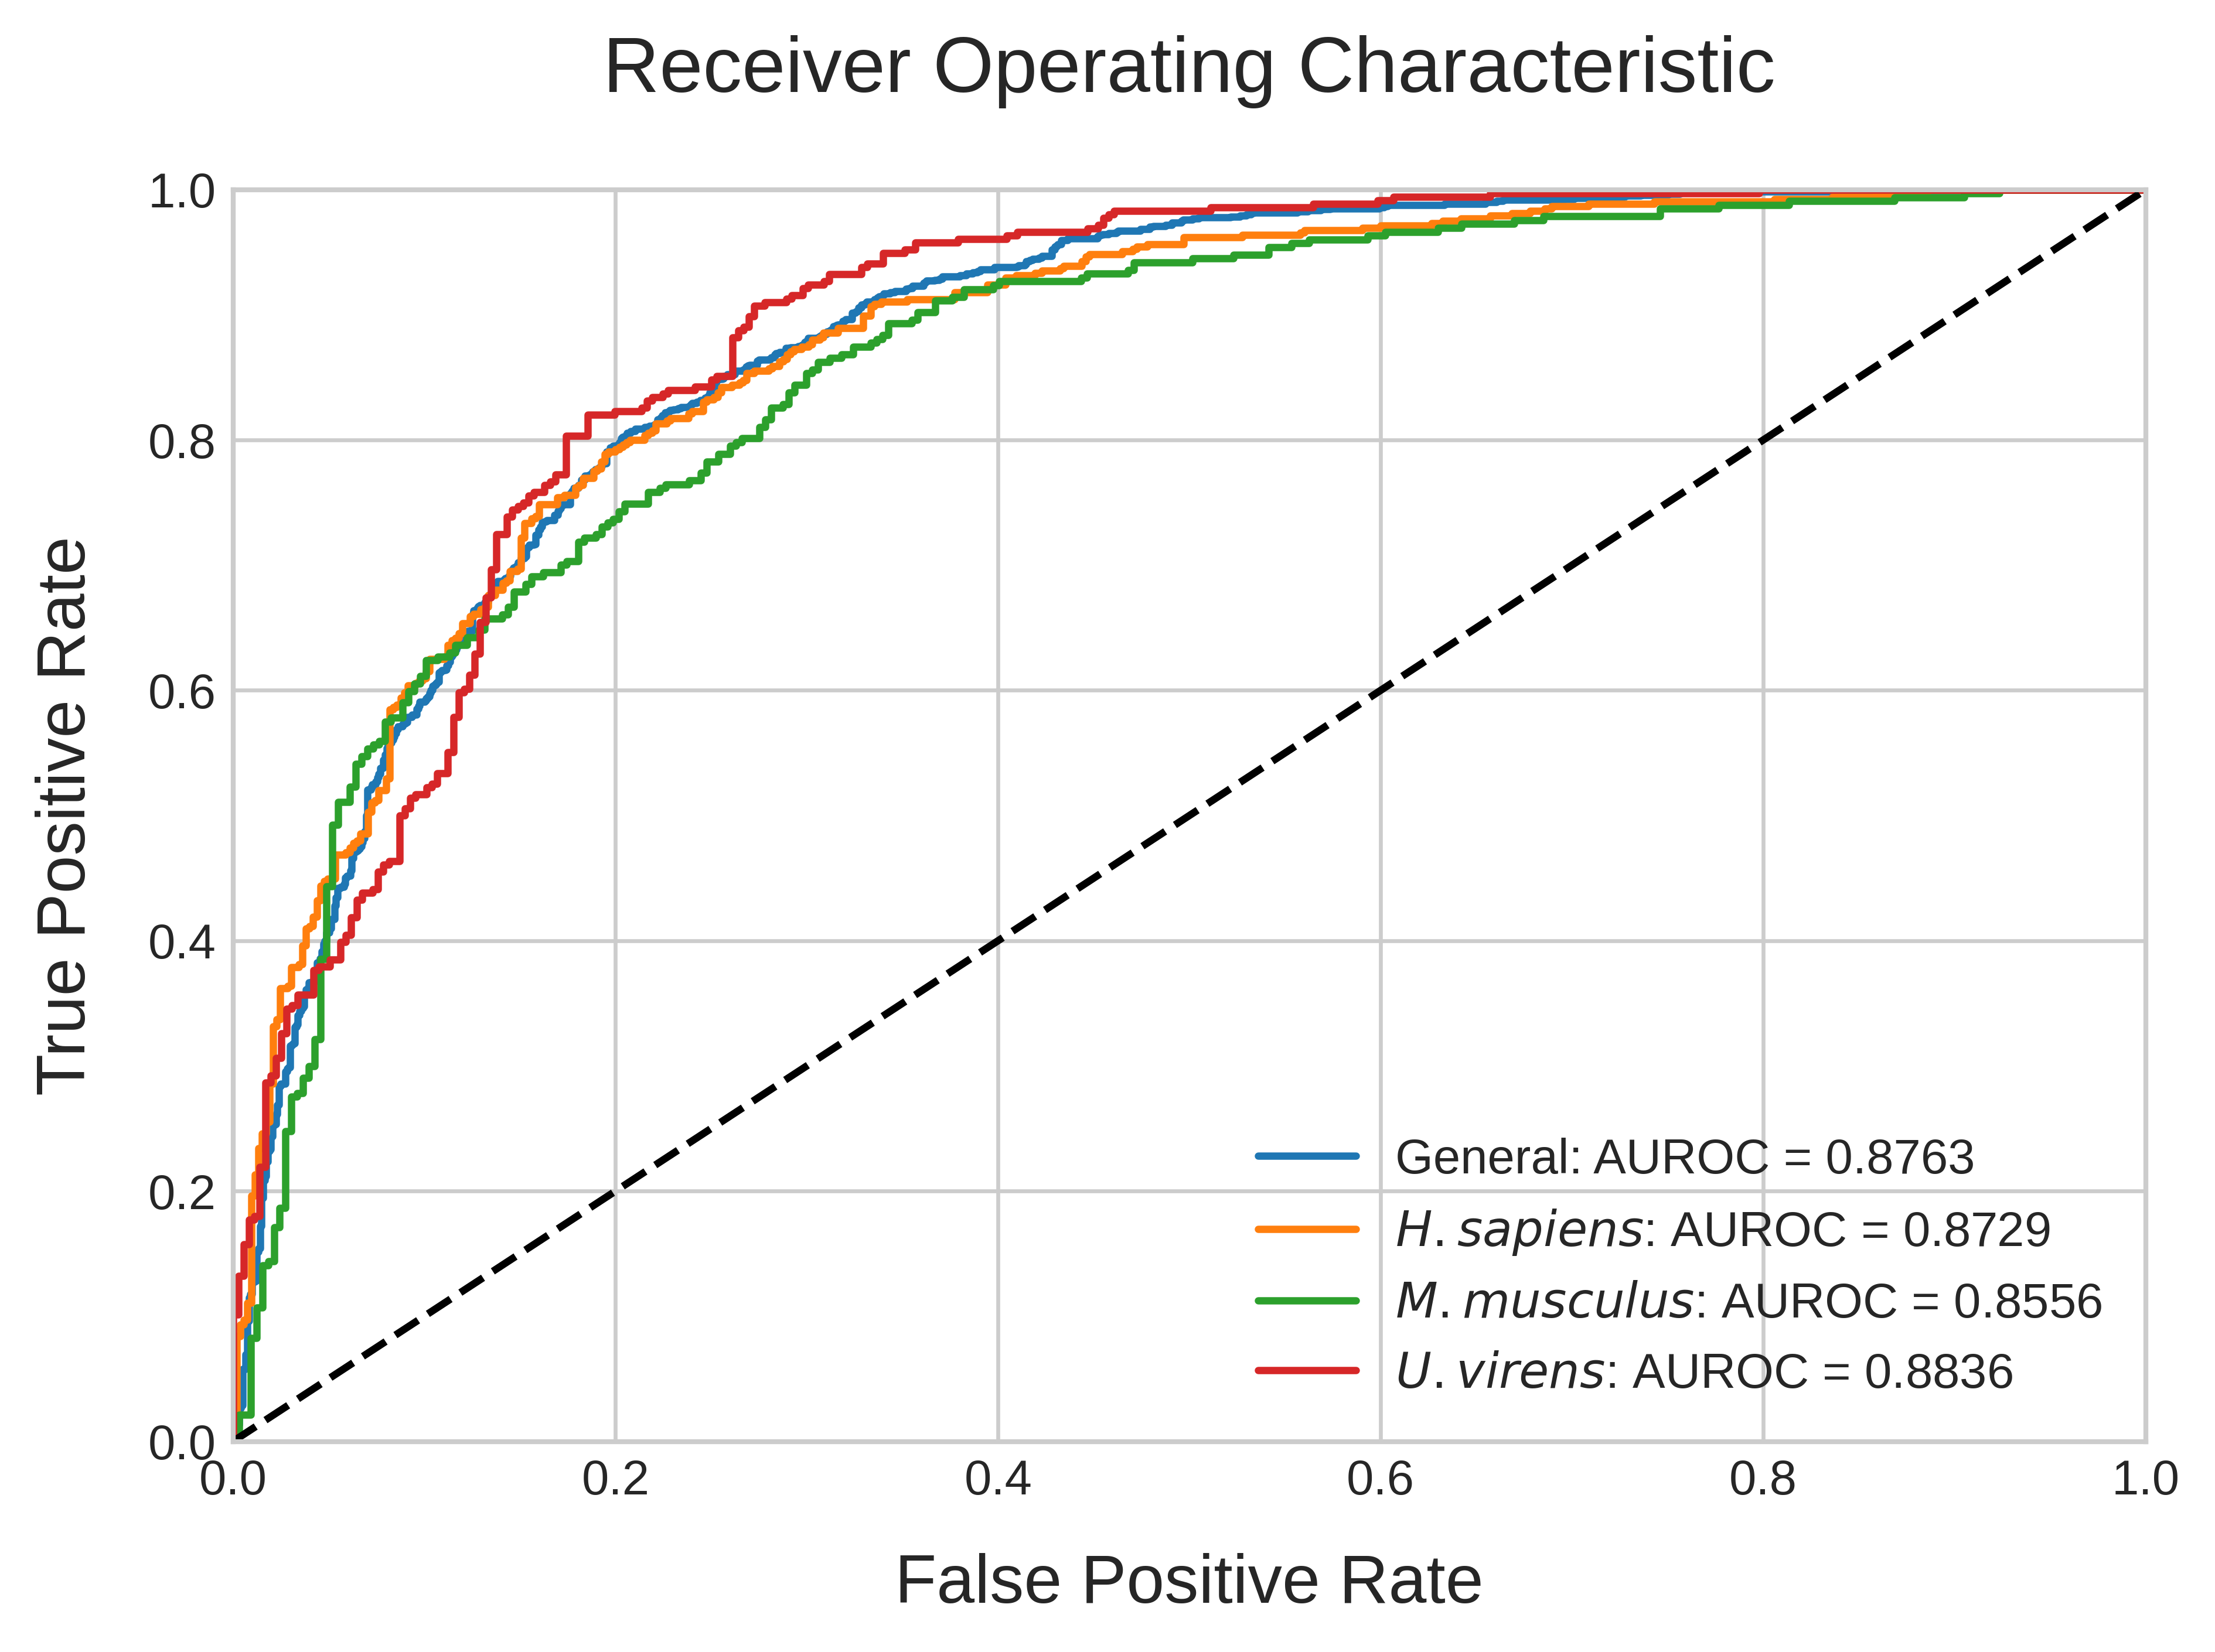

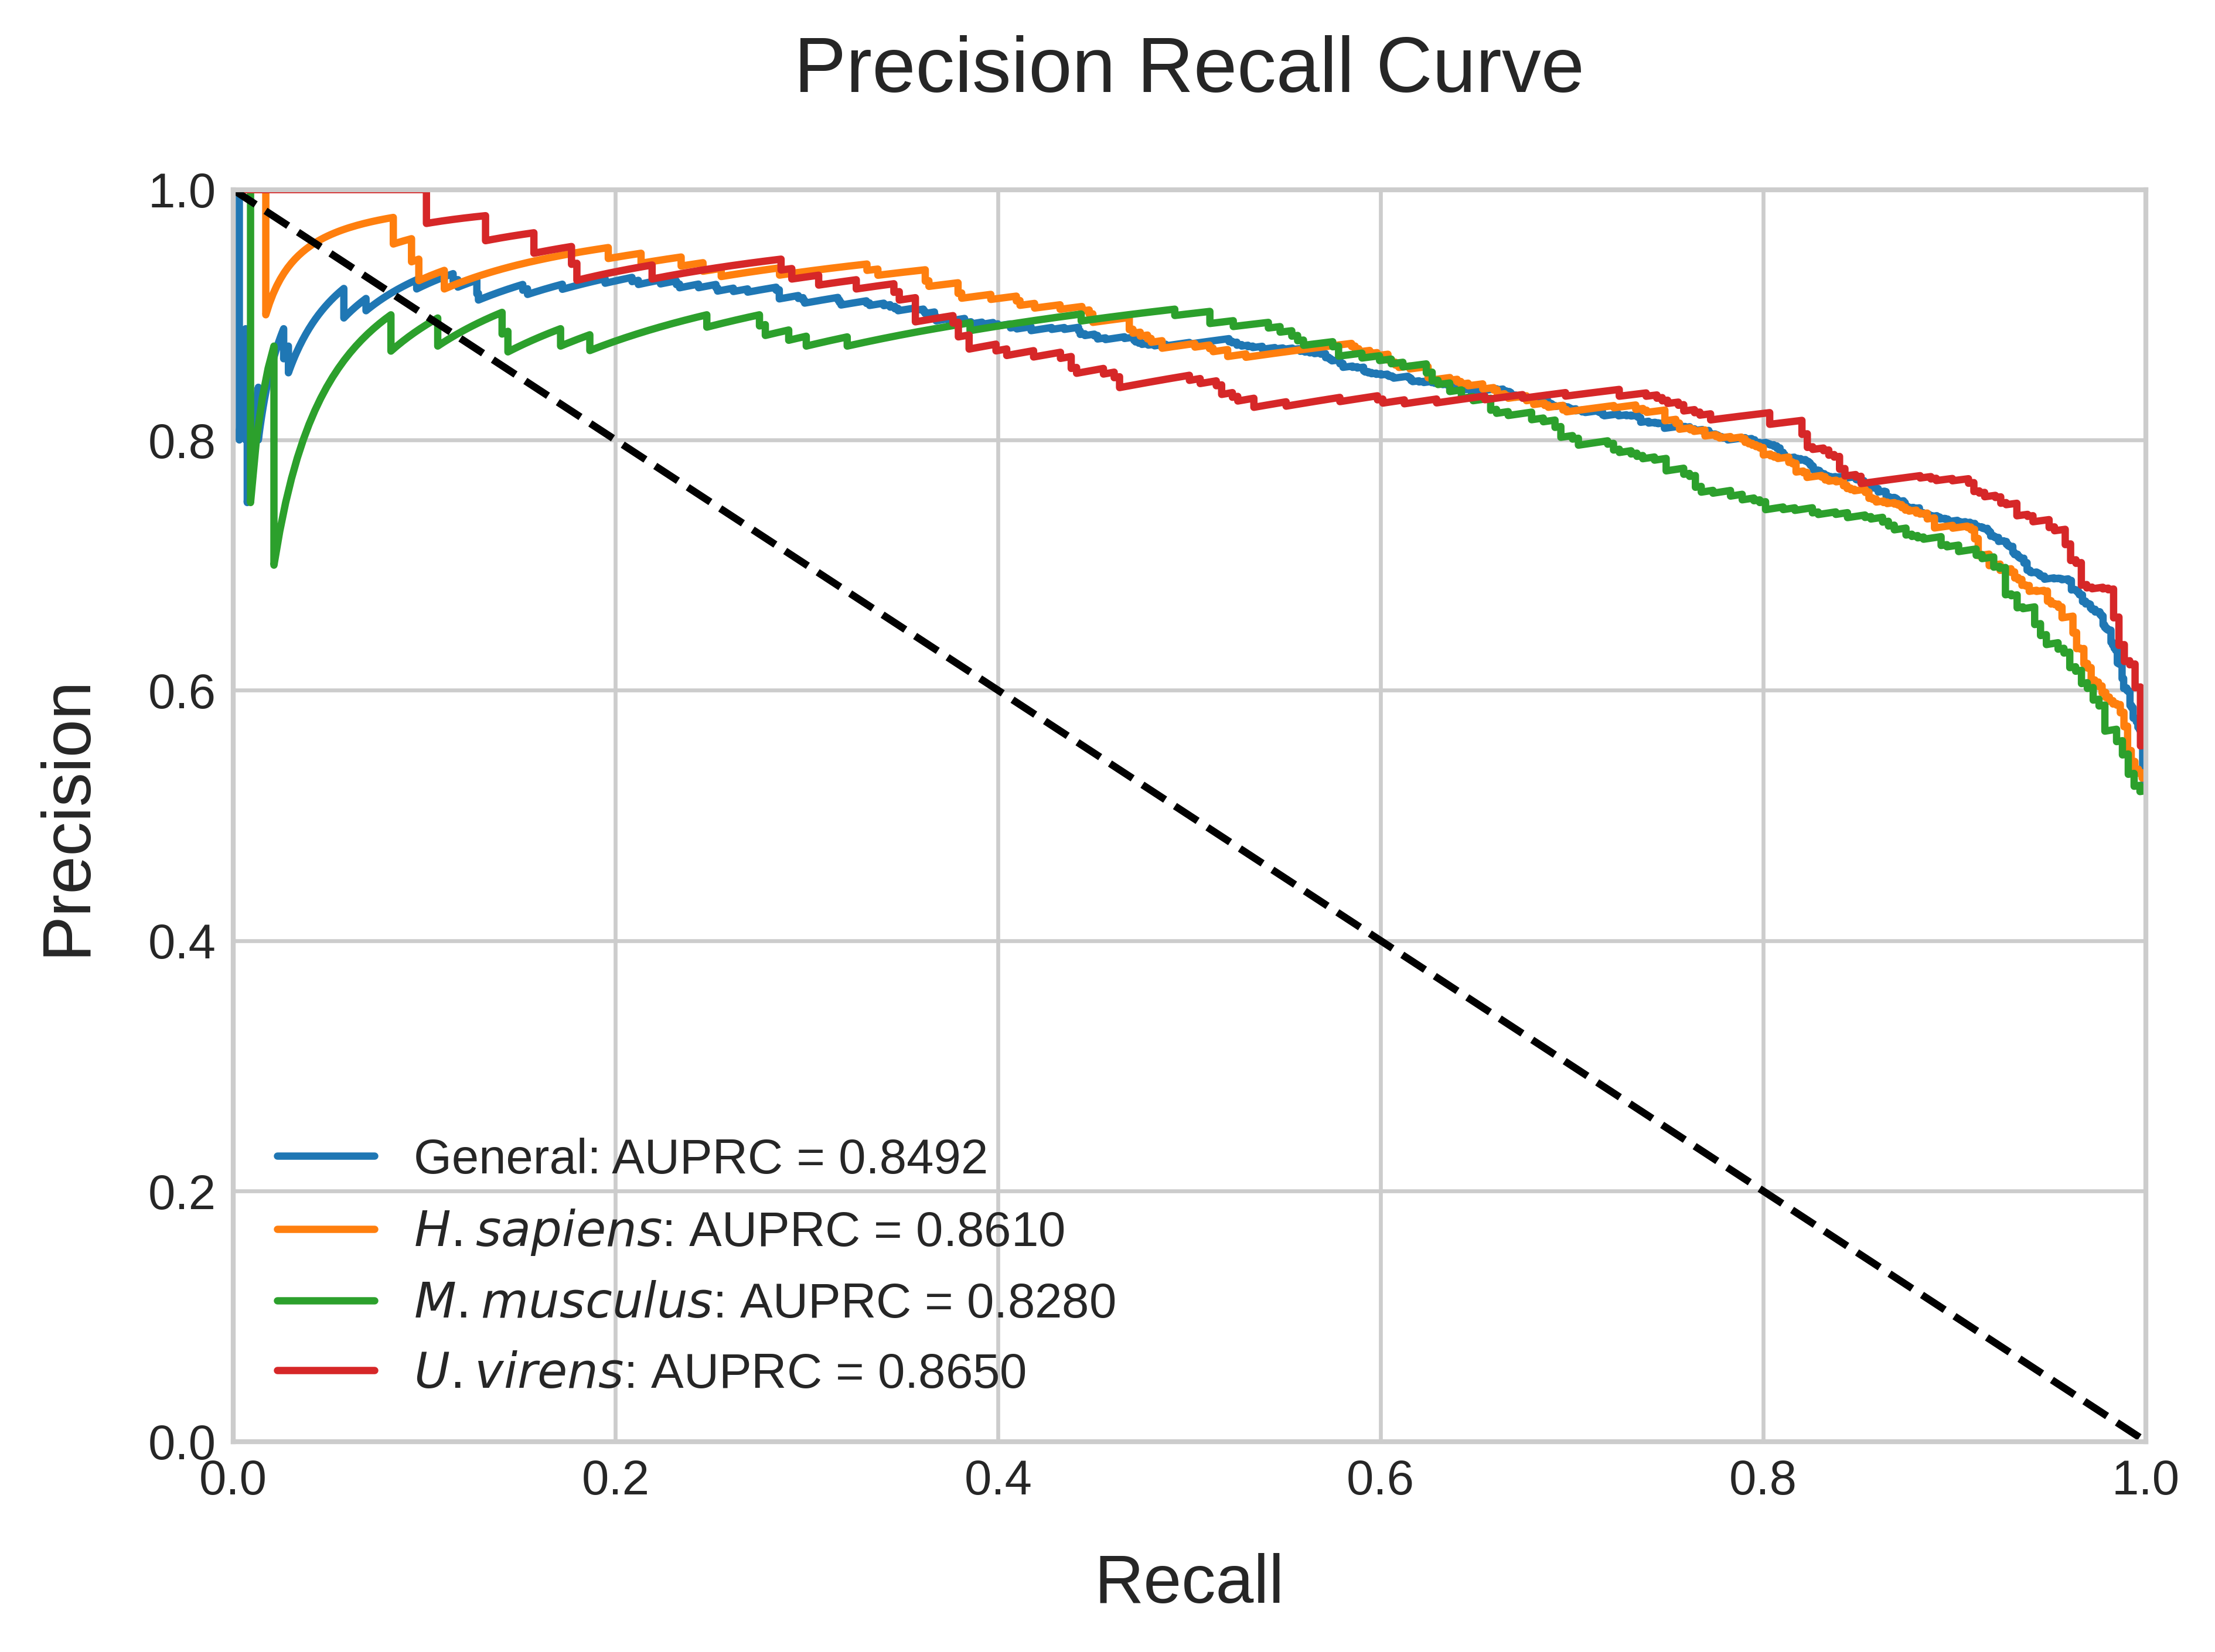

In [101]:
plot_project = osp.join(plot_dir, f'{project}')
os.makedirs(plot_project, exist_ok=True)
data = []
for sp_pred in ['general', 'human', 'mouse', 'false_smut']:
    project = f'{sp_pred}_struct_plm'
    root_dir = f'result/SLAM_combine/{project}'
    logits_file = osp.join(root_dir, 'logits_results.txt')
    df = pd.read_csv(logits_file, sep='\t')
    test_probs = np.array(df['Logit'].tolist())
    test_labels = np.array(df['Label'].tolist())
    data.append(np.array([test_labels, test_probs]))
    acc_, th_, rec_, pre_, f1_, spe_, mcc_, auc_, pred_class, auprc_, tn, fp, fn, tp = eval_metrics(test_probs, test_labels)
    pred_bi = np.abs(np.ceil(test_probs - th_))
    cm = confusion_matrix(test_labels, pred_bi)
    plot_confusion_matrix(cm, osp.join(plot_project, f'{sp_pred}_confusion_matrix.png'), cmap=plt.cm.GnBu)
draw_AUROC(data, osp.join(plot_project, 'AUROC.png'), splist=['General', 'H. sapiens', 'M. musculus', 'U. virens'])
draw_AUPRC(data, osp.join(plot_project, 'AUPRC.png'), splist=['General', 'H. sapiens', 'M. musculus', 'U. virens'])

## 2.2. Species-specific performance

In [108]:
perf_ind = {'f1':6,'mcc':8,'auroc':9, 'auprc':10}

In [185]:
def draw_sp_performance(results_list, perf, cmap=plt.cm.Purples):
    perf_ind = {'f1':6,'mcc':8,'auroc':9, 'auprc':10}
    dat = np.array([line[perf_ind[perf]] for line in results_list]).reshape(4,4)
    n = 'General'
    n1 = 'H. sapiens'
    n2 = 'M. musculus'
    n3 = 'U. virens'
    alphabets =  [f'General',rf'${n1}$', rf'${n2}$', rf'${n3}$']
    vmin = 0.5 # dat.min()
    vmax = 1 # dat.max()
    figure = plt.figure() 
    axes = figure.add_subplot(111) 
    plt.grid(False)
    caxes = axes.matshow(dat, interpolation ='nearest', cmap=cmap, origin ='lower') 
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = figure.colorbar(im)
    interval = 0.1
    cbar.set_ticks([vmin, vmin+interval, vmin+interval*2, vmin+interval*3, vmin+interval*4, vmax])
    
    cbar.set_ticklabels([f'{vmin:.2f}', f'{vmin+interval:.2f}', f'{vmin+interval*2:.2f}', f'{vmin+interval*3:.2f}', f'{vmin+interval*4:.2f}', f'{vmax:.2f}'])

    for i in range(4):
        for j in range(4):
            c = dat[i][j]
            if c > 0.001:
                plt.text(j, i, f"{c:.2f}", color='black', fontsize=10, va='center', ha='center')
    axes.set_xticklabels([' ']+alphabets, fontsize=10)
    axes.tick_params(axis='x', direction='out', pad=10)
    axes.set_yticklabels([' ']+alphabets, fontsize=10) 
    plt.ylabel('Models', fontsize=14, labelpad=10) # , fontweight='bold')
    plt.xlabel('Datasets', fontsize=14, labelpad=10) #, fontweight='bold')
    axes.xaxis.set_label_position('bottom') 
    axes.xaxis.tick_bottom()
    plt.tight_layout()
    plt.savefig(f'Plots/cross_species_{perf}.png', dpi=600)

/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


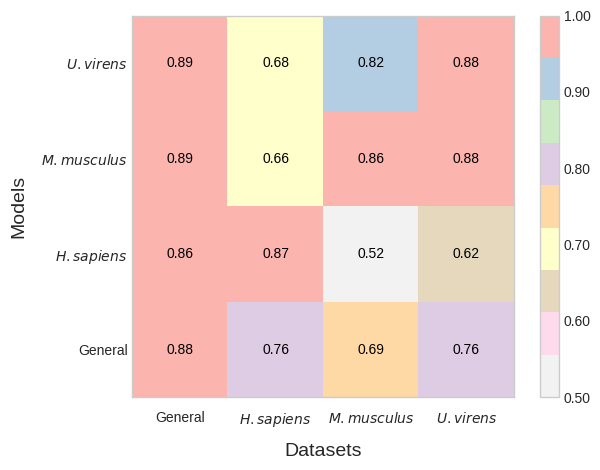

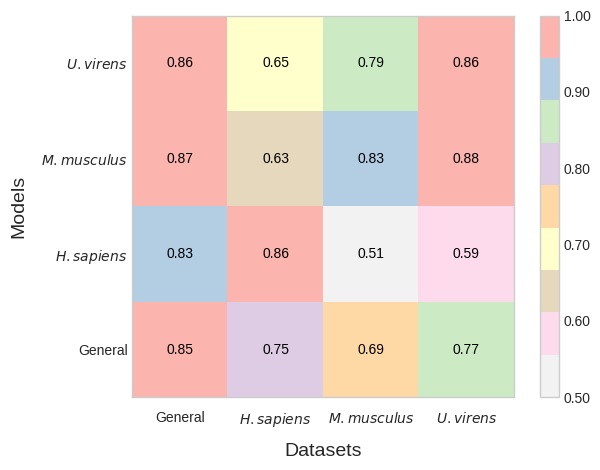

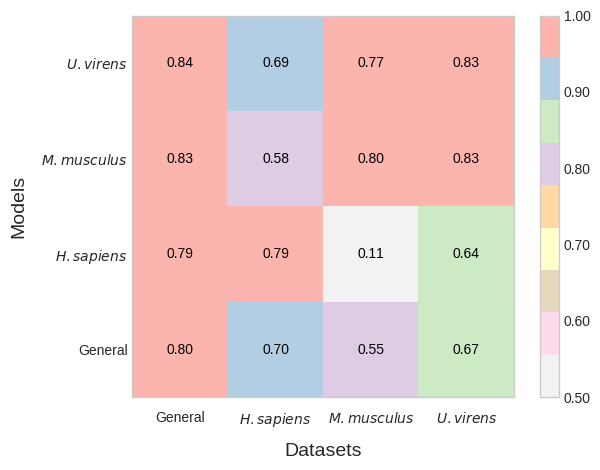

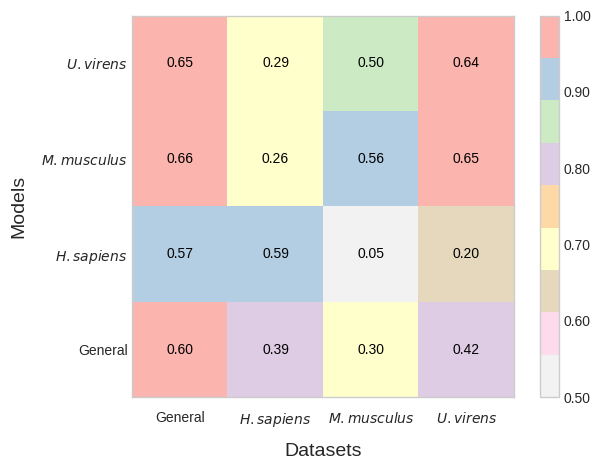

In [188]:
for perf in ['auroc', 'auprc']:
    draw_sp_performance(results_list, perf, cmap=plt.cm.Pastel1_r)
for perf in ['f1', 'mcc']:
    draw_sp_performance(results_list, perf, cmap=plt.cm.Pastel1_r)

# 3. t-SNE visualization

In [58]:
import pickle
with open('result/embedding.pkl', 'wb') as pk:
    pickle.dump(species_embedding, pk)

In [59]:
import pickle
with open('result/embedding.pkl', 'rb') as f:
    sp_emd = pickle.load(f)

In [102]:
emd_list = sp_emd['general'][0].keys()

general | cnn_out:	 (2416, 32)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


general | bert_out:	 (2416, 52224)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


general | plm_out:	 (2416, 16)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


general | raw:	 (2416, 1632)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


general | lstm_out:	 (2416, 64)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


general | fea_in:	 (2416, 2091)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


general | fea_out:	 (2416, 32)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


general | gnn_out:	 (2416, 16)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


general | fusion_out:	 (2416, 160)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


general | attn_out:	 (2416, 160)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


general | final_out:	 (2416, 5)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


human | cnn_out:	 (1050, 32)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


human | bert_out:	 (1050, 52224)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


human | plm_out:	 (1050, 16)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


human | raw:	 (1050, 1632)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


human | lstm_out:	 (1050, 64)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


human | fea_in:	 (1050, 2091)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


human | fea_out:	 (1050, 32)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


human | gnn_out:	 (1050, 16)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


human | fusion_out:	 (1050, 160)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


human | attn_out:	 (1050, 160)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


human | final_out:	 (1050, 5)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


mouse | cnn_out:	 (654, 32)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


mouse | bert_out:	 (654, 52224)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


mouse | plm_out:	 (654, 16)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


mouse | raw:	 (654, 1632)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


mouse | lstm_out:	 (654, 64)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


mouse | fea_in:	 (654, 2091)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


mouse | fea_out:	 (654, 32)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


mouse | gnn_out:	 (654, 16)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


mouse | fusion_out:	 (654, 160)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


mouse | attn_out:	 (654, 160)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


mouse | final_out:	 (654, 5)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


false_smut | cnn_out:	 (712, 32)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


false_smut | bert_out:	 (712, 52224)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


false_smut | plm_out:	 (712, 16)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


false_smut | raw:	 (712, 1632)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


false_smut | lstm_out:	 (712, 64)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


false_smut | fea_in:	 (712, 2091)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


false_smut | fea_out:	 (712, 32)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


false_smut | gnn_out:	 (712, 16)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


false_smut | fusion_out:	 (712, 160)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


false_smut | attn_out:	 (712, 160)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


false_smut | final_out:	 (712, 5)


/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhqin/anaconda3/envs/pyg/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


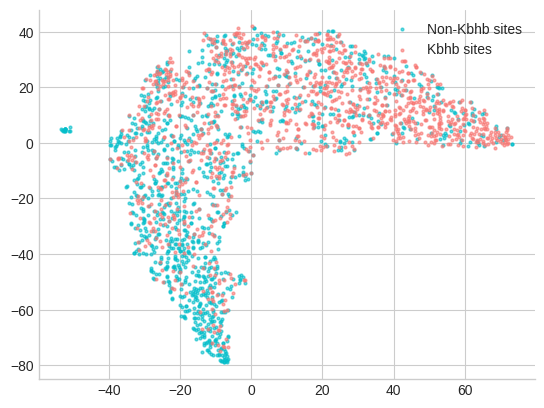

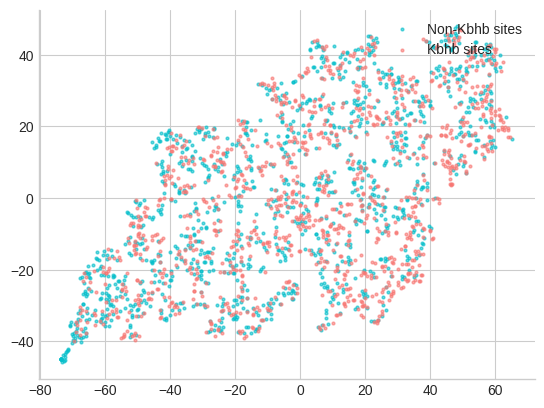

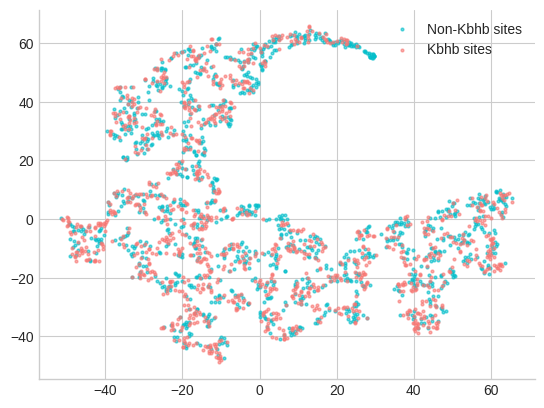

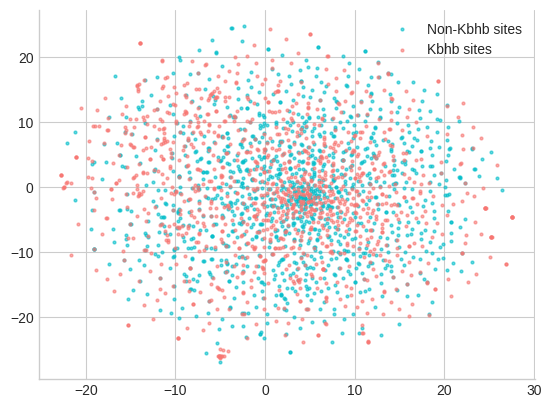

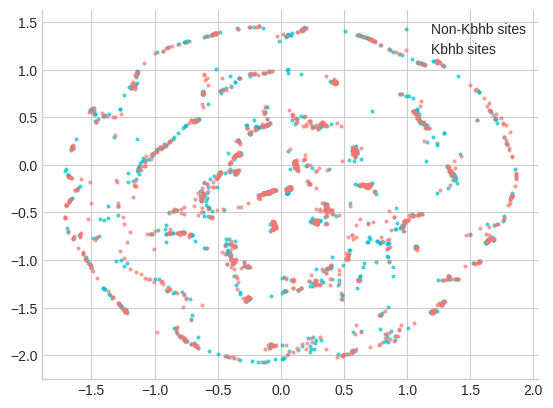

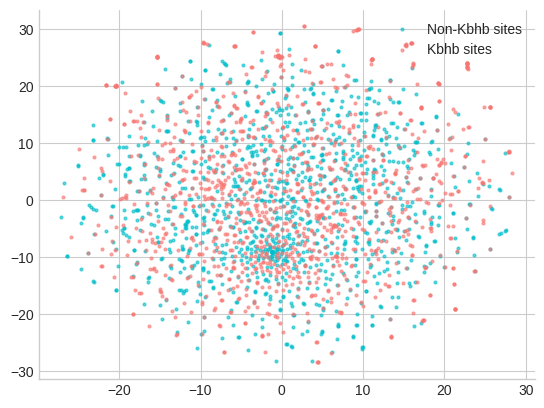

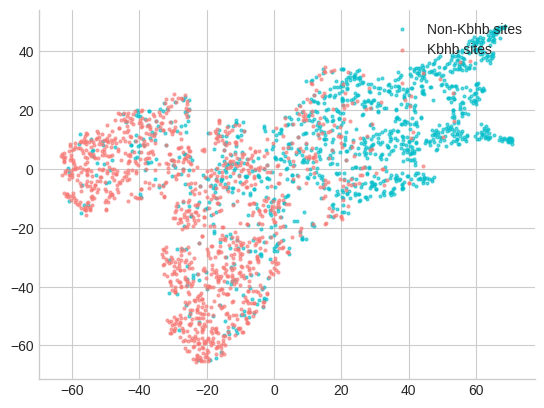

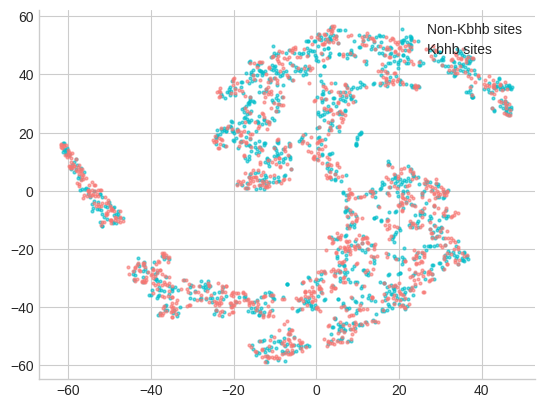

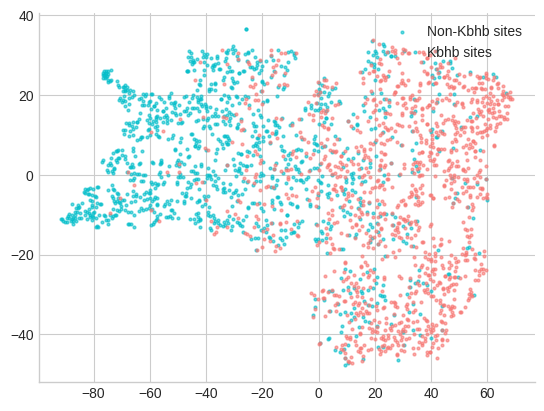

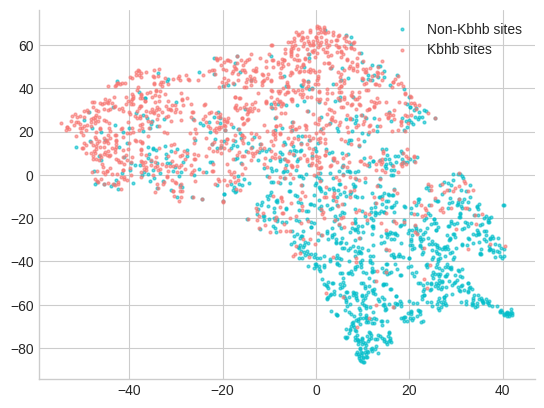

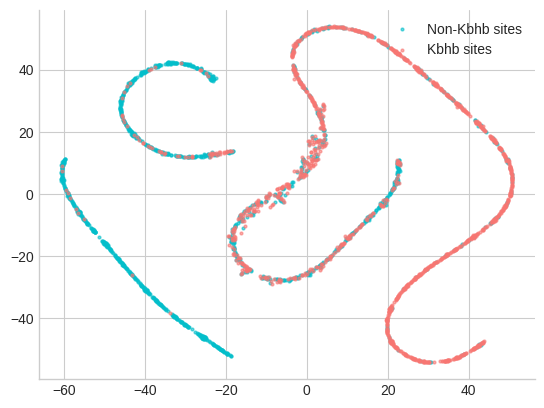

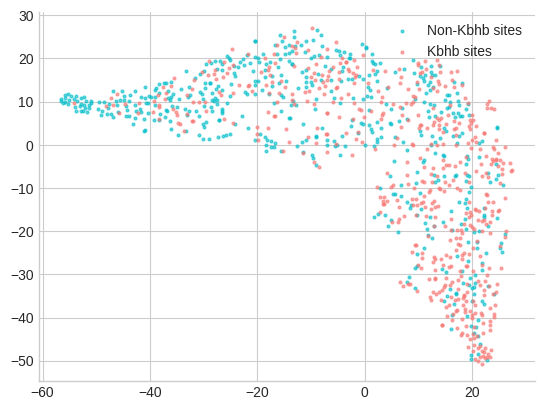

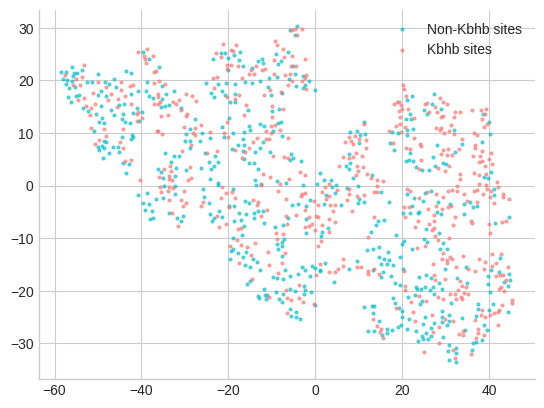

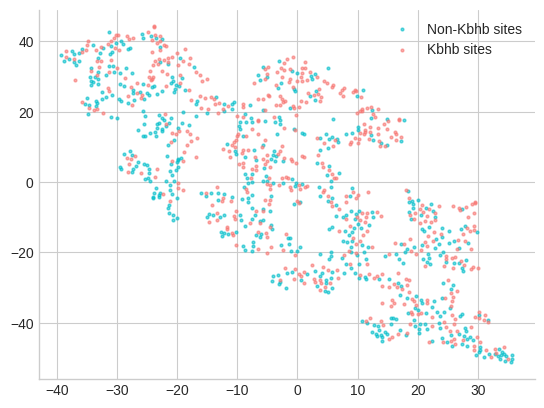

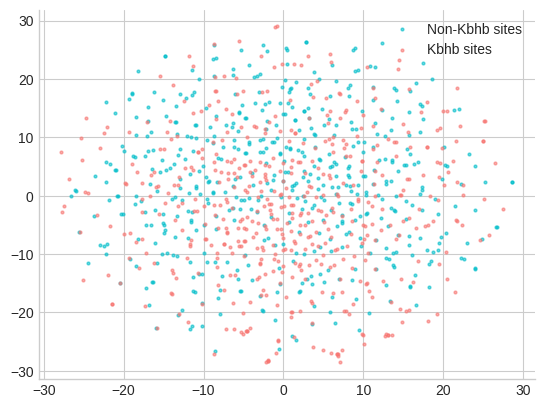

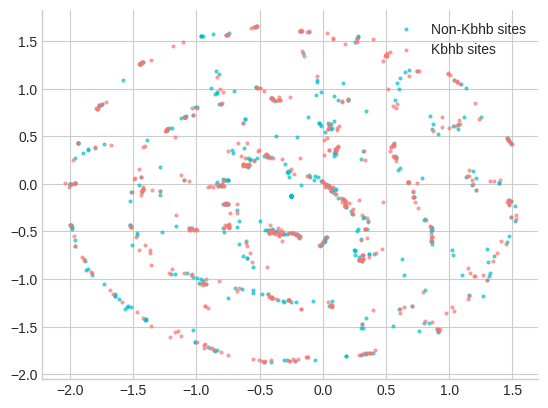

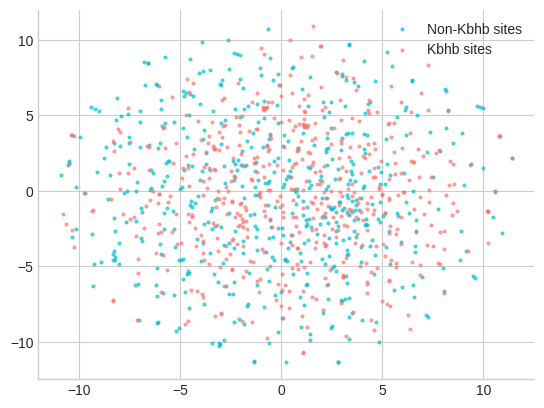

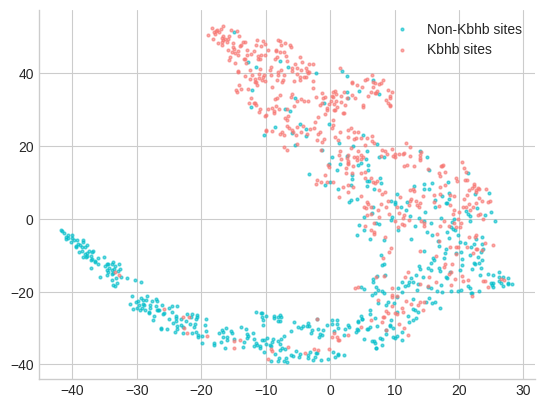

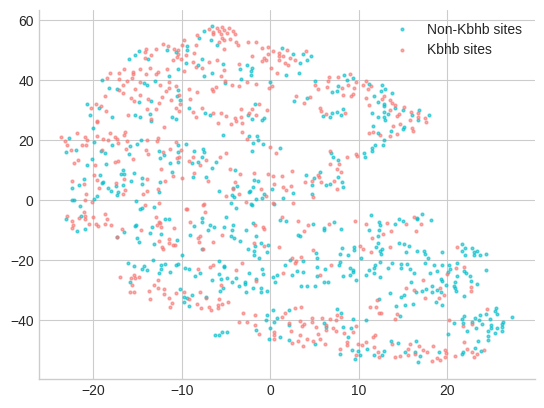

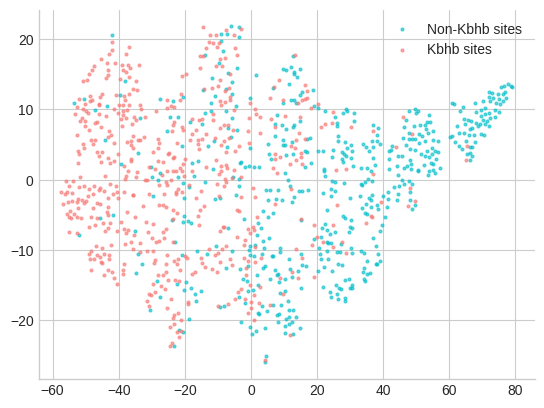

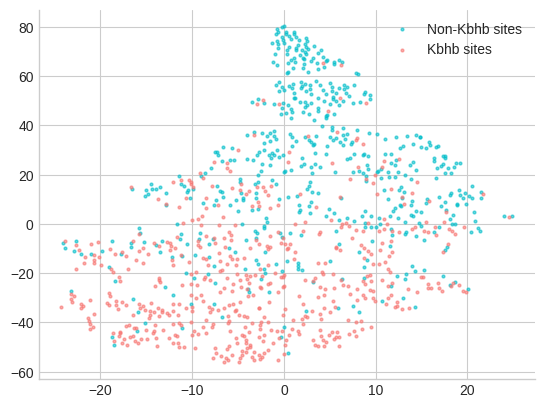

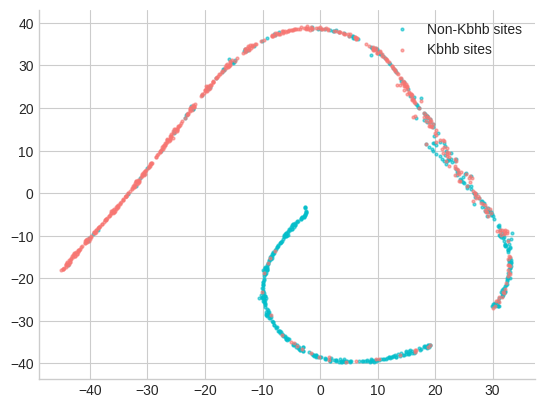

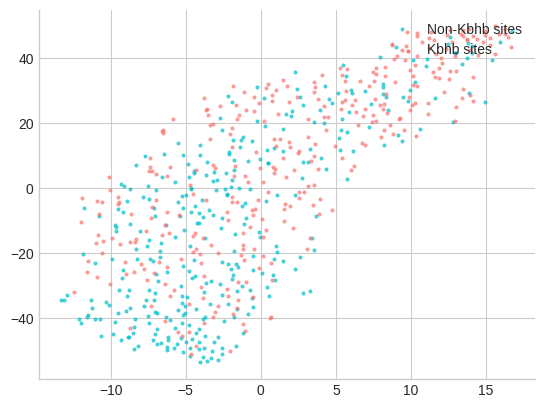

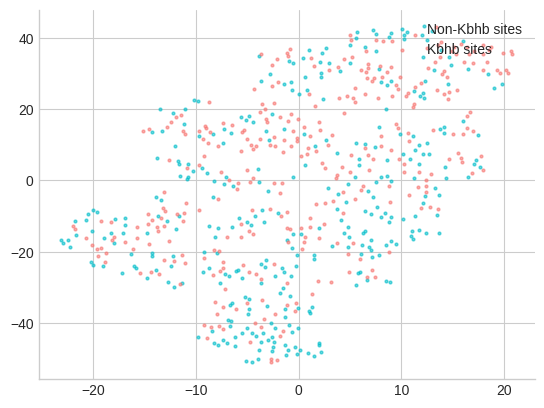

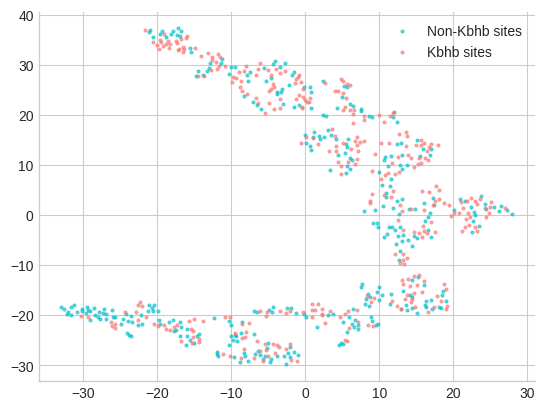

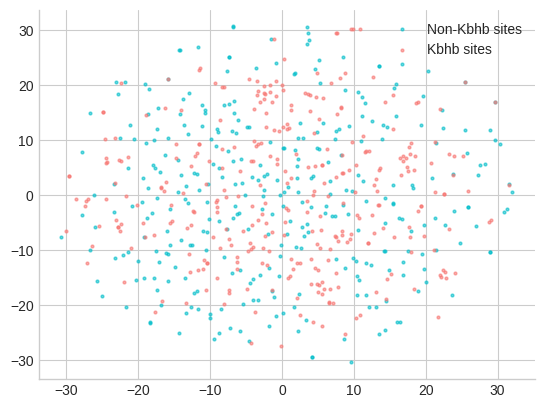

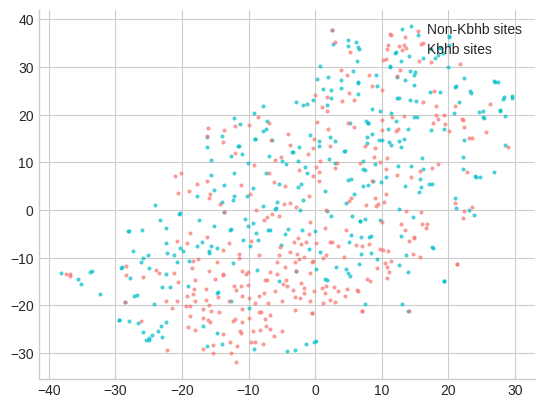

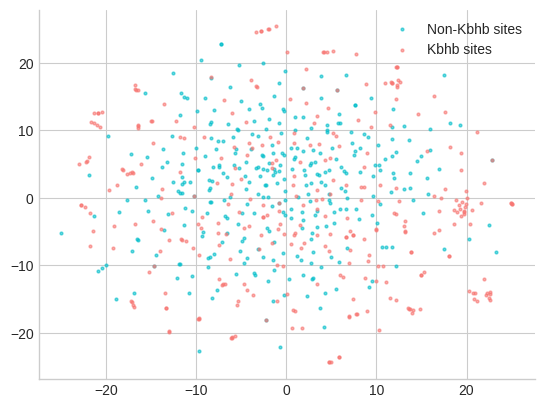

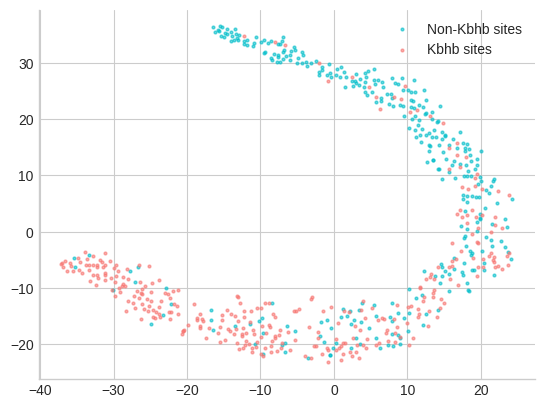

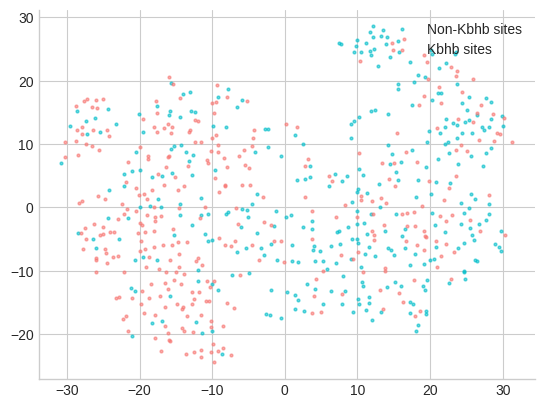

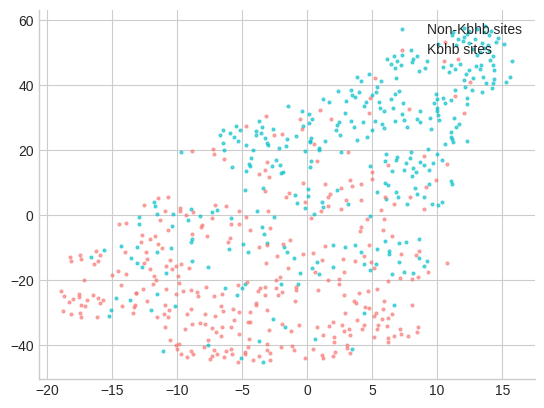

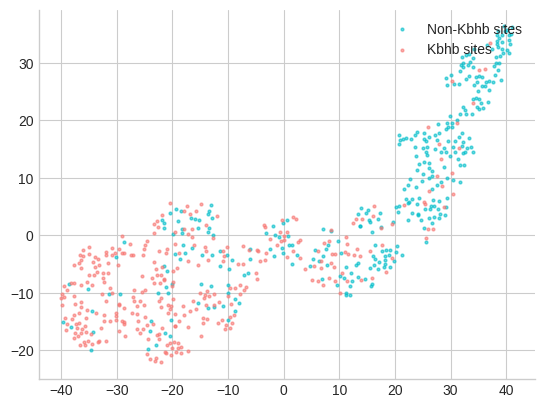

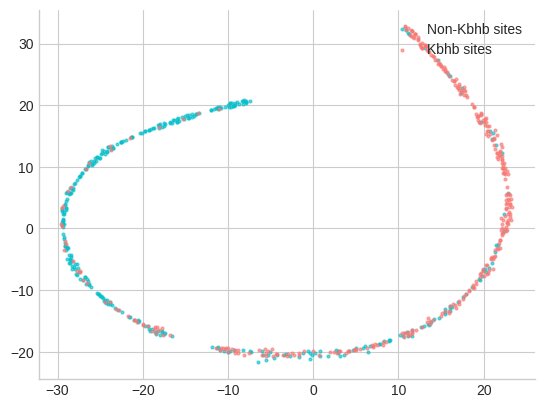

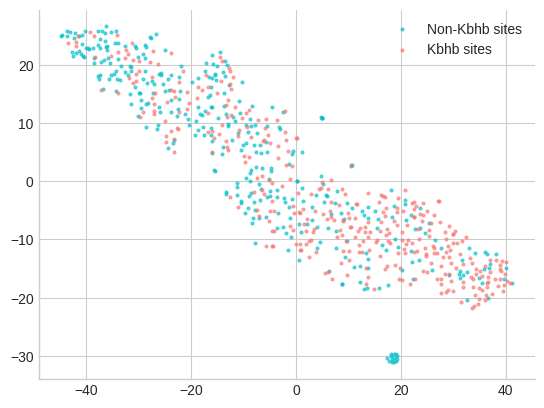

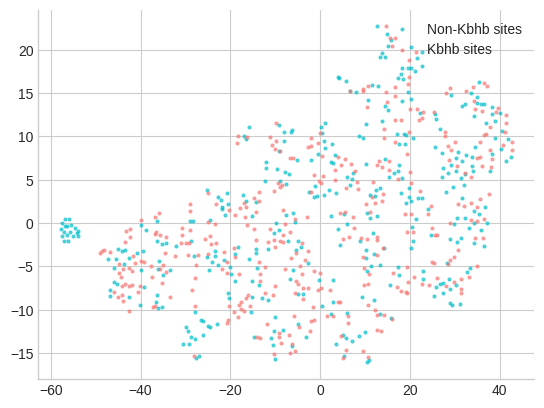

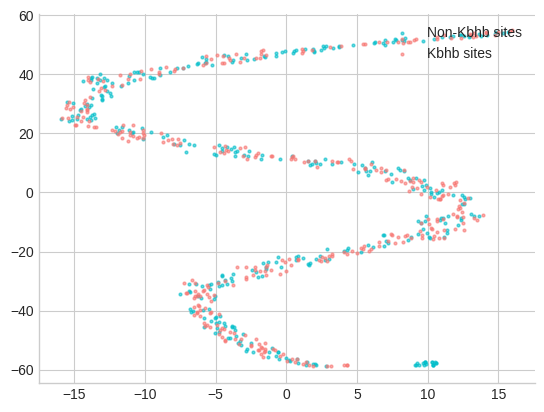

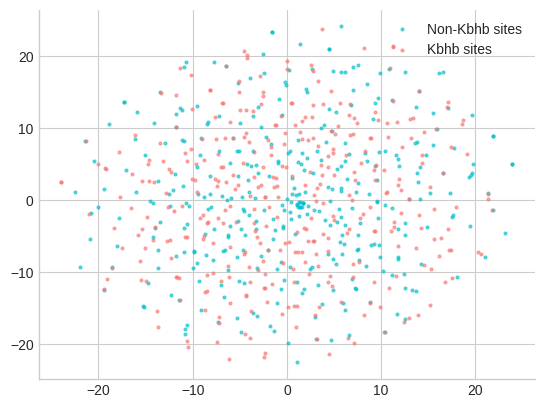

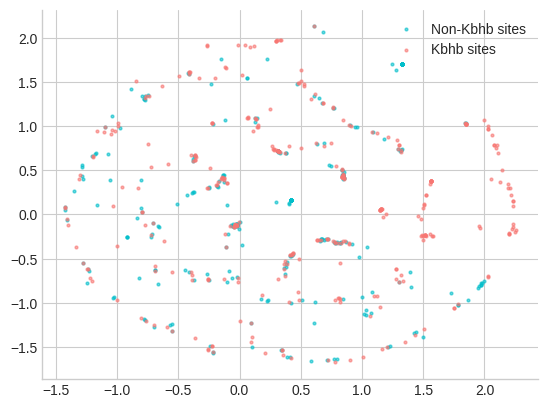

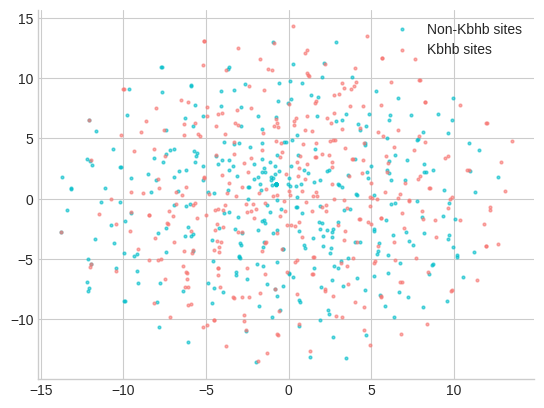

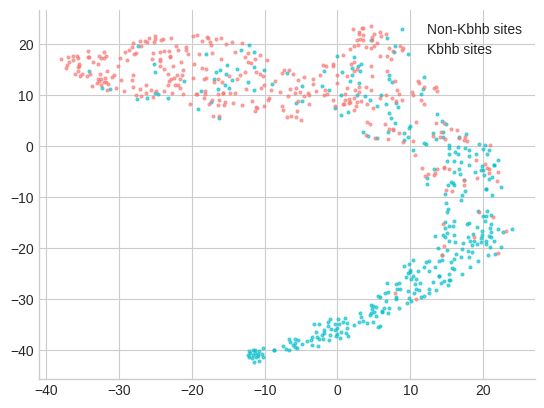

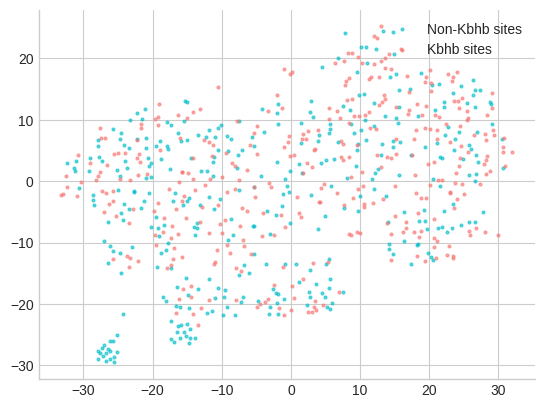

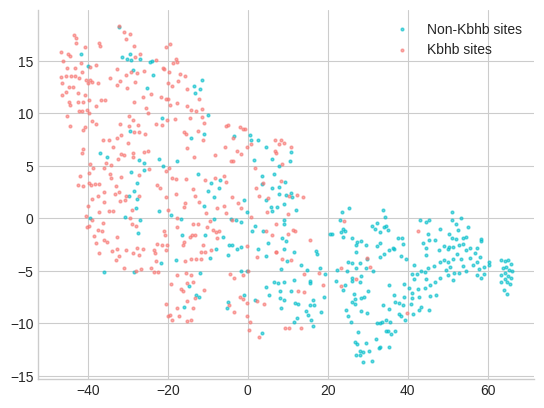

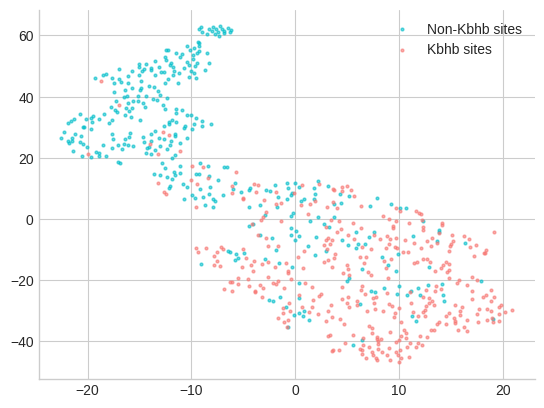

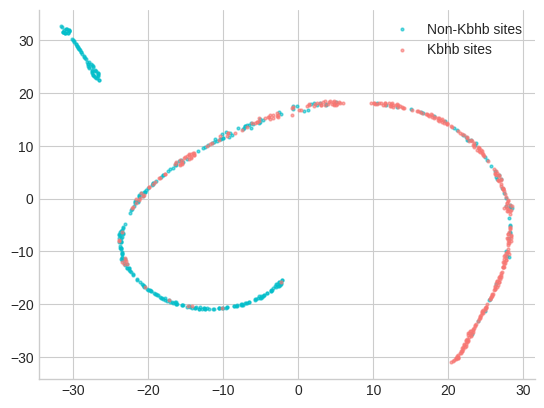

In [98]:
os.makedirs(osp.join(plot_project, f'tSNE'), exist_ok=True)
for sp in sp_emd.keys():
    emd_dict = dict(sp_emd[sp])
    test_targets = emd_dict['test_targets']
    for ind, (key) in enumerate(emd_list):
        data = emd_dict[key]
        data = np.concatenate(data, axis=0)
        if len(data.shape) > 2:
            data = data.reshape(data.shape[0], np.prod(data.shape[1:]))
        print(f'{sp} | {key}:\t', data.shape)
        save_path = osp.join(plot_project, f'tSNE/{sp}_{key}.png')
        draw_tsne(test_targets, data, save_path, ptm_type='Kbhb')

# 4. Ablation studies

In [271]:
df = pd.read_csv('ablation.txt', sep='\t')
df.columns = ['Experiment', 'Acc', 'Rec', 'Pre', 'F1', 'Spe', 'MCC', 'AUROC', 'AUPRC']
df['Experiment'] = ['SLAM', 'w/o structure', 'w/o ProtBert', 'w/o 1DCNN', 'w/o BiLSTM', 'w/o feature', 'w/o attention']
df = df.set_index('Experiment').loc[['w/o structure', 'w/o ProtBert', 'w/o 1DCNN', 'w/o BiLSTM', 'w/o feature', 'w/o attention', 'SLAM']].reset_index()
df

Experiment    Acc    Rec    Pre     F1    Spe    MCC  AUROC  AUPRC
0  w/o structure  0.773  0.873  0.728  0.794  0.674  0.557  0.856  0.831
1   w/o ProtBert  0.779  0.776  0.780  0.778  0.781  0.558  0.854  0.825
2      w/o 1DCNN  0.793  0.808  0.784  0.796  0.777  0.586  0.870  0.846
3     w/o BiLSTM  0.796  0.858  0.763  0.808  0.734  0.596  0.867  0.839
4    w/o feature  0.782  0.851  0.748  0.796  0.713  0.569  0.853  0.824
5  w/o attention  0.788  0.801  0.780  0.791  0.774  0.576  0.860  0.829
6           SLAM  0.799  0.803  0.796  0.800  0.795  0.598  0.876  0.849

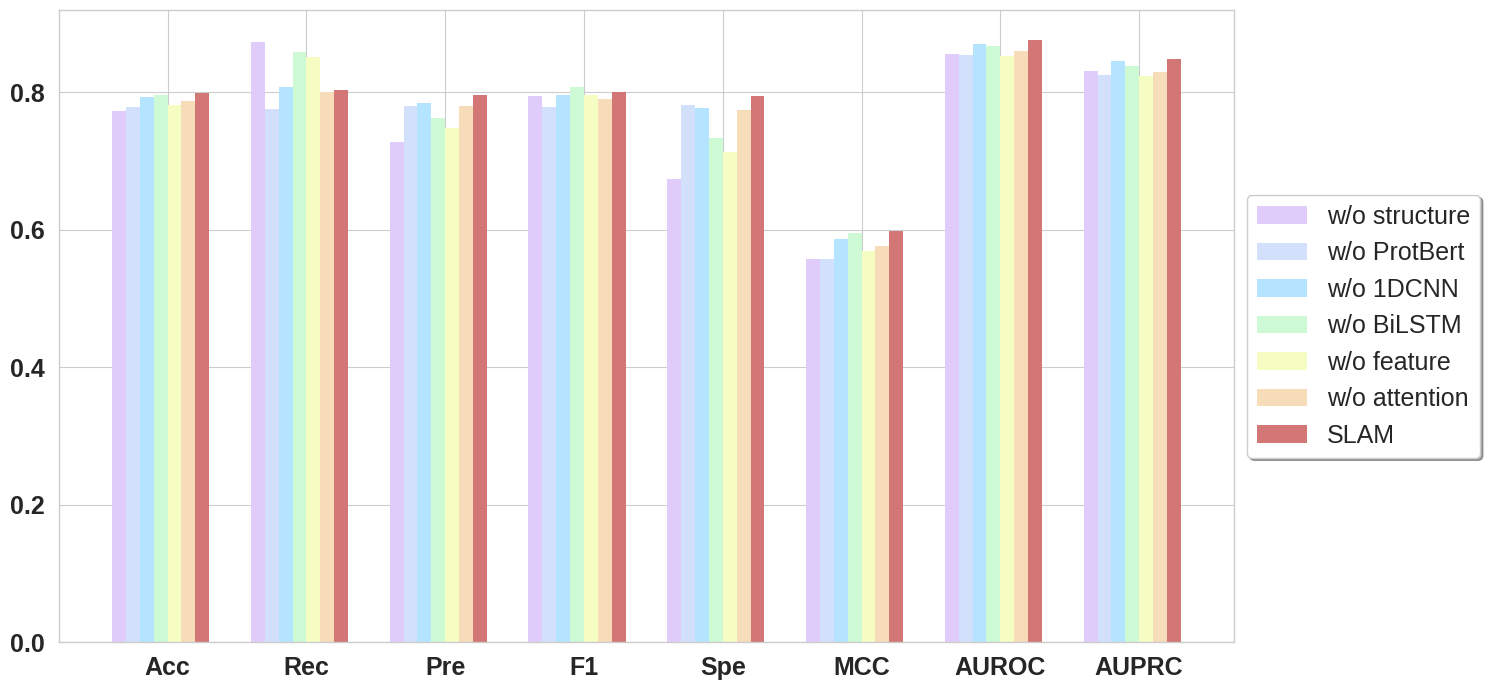

In [276]:
plt.figure(figsize=(15, 7))
plt.style.use('seaborn-whitegrid')
# plt.grid(False)
bar_width = 0.1
exps = df['Experiment'].unique()
metrics = df.columns[1:]
index = np.arange(len(metrics))
color_list = ['#DFCCFB','#D2E0FB', '#B4E4FF','#CDFAD5','#F6FDC3','#F7DCB9','#D37676']
for i, name in enumerate(exps):
    scores = df[df['Experiment'] == name][metrics].values.flatten()
    plt.bar(index + i * bar_width, scores, bar_width, label=name, color=color_list[i])

plt.xticks(index + bar_width * (len(exps) / 2), metrics, rotation=0, fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
# plt.yticks(np.arange(0, 1.1, 0.2), fontsize=18, fontweight='bold')
# plt.legend(fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18, frameon=True, fancybox=True, shadow=True)
plt.gca().tick_params(axis='x', pad=10)
plt.gca().tick_params(axis='y', pad=10)
plt.tight_layout()
plt.savefig('Plots/ablation.tiff', dpi=600)

# 5. Others

## 5.1. AF2 pLDDT scores

In [281]:
score_df = pd.read_csv('Datasets/Structure/score.csv', sep='\t')
score_df

ID      plddt   ptm
0     A0A063BID6  96.082738  0.93
1     A0A063BID9  85.421923  0.74
2     A0A063BIE4  92.374421  0.91
3     A0A063BIE5  56.528593  0.34
4     A0A063BK30  86.152733  0.76
...          ...        ...   ...
3039      Q9Z239  68.882500  0.39
3040      Q9Z2D6  53.229876  0.32
3041      Q9Z2I0  66.193279  0.60
3042      Q9Z2I8  88.573141  0.79
3043      Q9Z2I9  86.539719  0.79

[3044 rows x 3 columns]

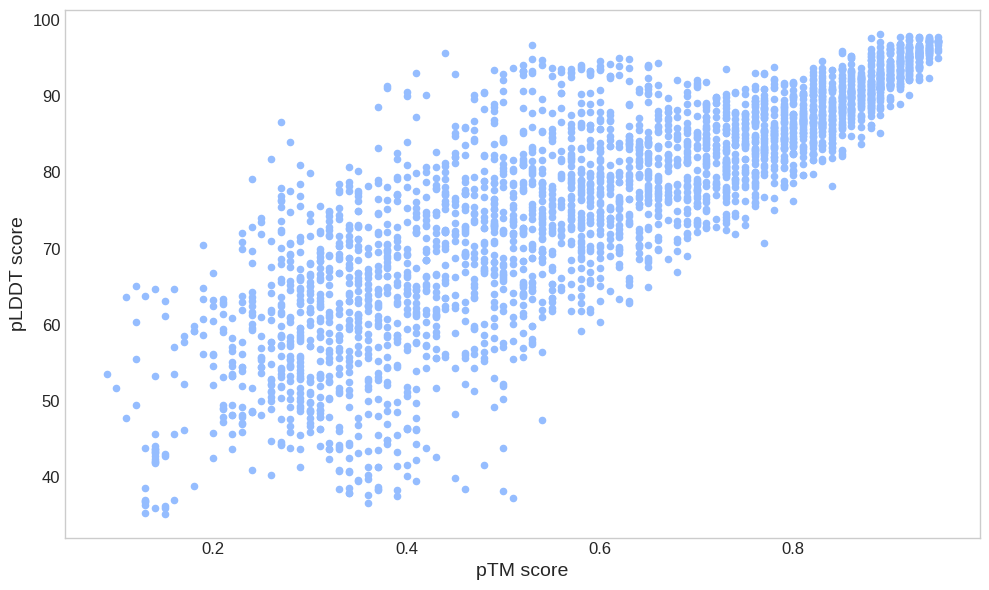

In [315]:
plt.figure(figsize=(10, 6))
plt.scatter(score_df['ptm'], score_df['plddt'], color='#95BDFF', marker='o', s=20)
plt.xlabel('pTM score', fontsize=14)
plt.ylabel('pLDDT score', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)
plt.tight_layout()
plt.savefig('Plots/structure_plddt_ptm_score.pdf', dpi=600)

## 5.1. protein graph

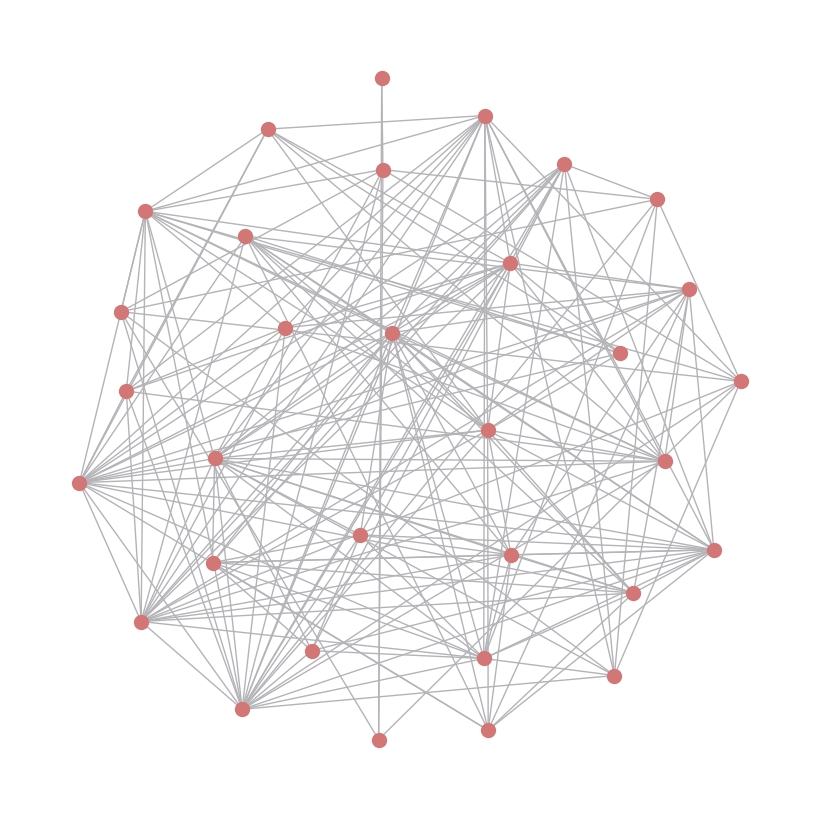

In [5]:
import torch_geometric
import networkx as nx
from SLAM_combine import *
pdb_path='../Datasets/Structure/PDB/Q9UBE0.pdb'
nn = 32
X = torch.tensor(parse_pdb(pdb_path, pos=32, atom_type='CA', nneighbor=32, cal_cb=True)).float()
query_atom = X[:, 1]
edge_index = radius_graph(query_atom, r=10, loop=False, max_num_neighbors=32, num_workers = 4)

data = torch_geometric.data.Data(x=np.arange(32), edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
plt.figure(figsize=(8, 8))
pos = nx.arf_layout(g)
self_loops = list(nx.selfloop_edges(g))
g.remove_edges_from(self_loops)
nx.draw(g, pos, node_color='#D37676', node_size=100, edge_color='#B4B4B8', font_size=16, font_weight='bold')
plt.savefig(f'Plots/protein_graph.png', dpi=600)

## 5.2. Plot features

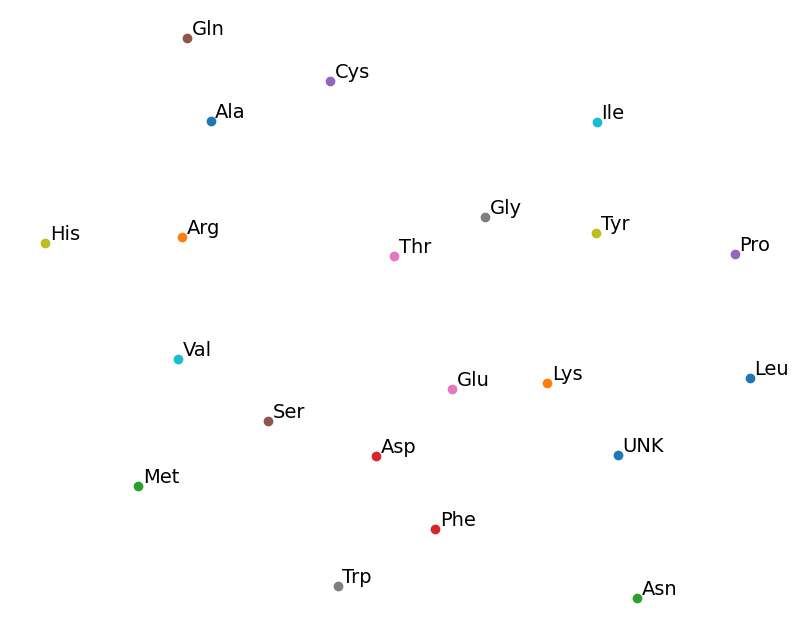

In [7]:
from sklearn.manifold import TSNE
# Define 21 amino acids
amino_acids = [
    "Ala", "Arg", "Asn", "Asp", "Cys", 
    "Gln", "Glu", "Gly", "His", "Ile", 
    "Leu", "Lys", "Met", "Phe", "Pro", 
    "Ser", "Thr", "Trp", "Tyr", "Val", "UNK"
]

# Randomly generate 21 amino acids' feature vectors, each 50 dimensions
np.random.seed(42)  # For reproducibility
features = np.random.randn(len(amino_acids), 50)
features = features + 30
# Use t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, perplexity=5, random_state=42)  # Adjust perplexity here
features_2d = tsne.fit_transform(features)

# Visualization
plt.figure(figsize=(10, 8))
for i, label in enumerate(amino_acids):
    x, y = features_2d[i, :]
    plt.scatter(x, y)
    plt.text(x + 0.3, y + 0.3, label, fontsize=14)
# plt.title('t-SNE Visualization of Amino Acids')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.savefig('Plots/word_embedding.png',dpi=600)

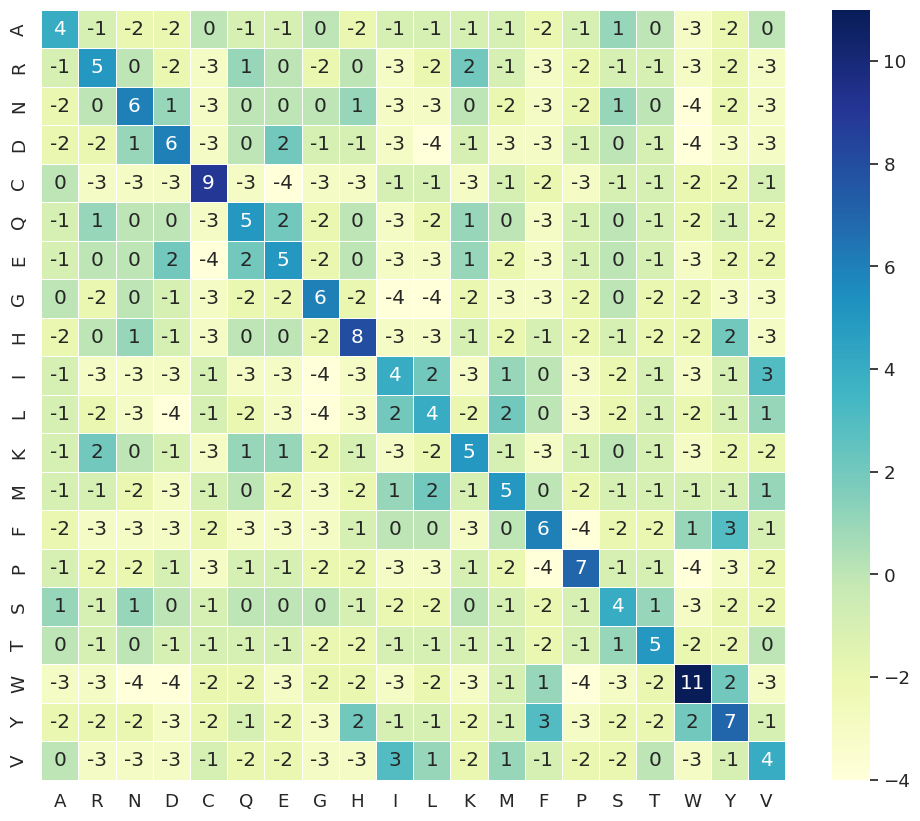

In [8]:
# Define amino acids and Blosum62 matrix
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 
            'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

blosum62 = {
    'A': [4,  -1, -2, -2, 0,  -1, -1, 0, -2,  -1, -1, -1, -1, -2, -1, 1,  0,  -3, -2, 0],  # A
    'R': [-1, 5,  0,  -2, -3, 1,  0,  -2, 0,  -3, -2, 2,  -1, -3, -2, -1, -1, -3, -2, -3], # R
    'N': [-2, 0,  6,  1,  -3, 0,  0,  0,  1,  -3, -3, 0,  -2, -3, -2, 1,  0,  -4, -2, -3], # N
    'D': [-2, -2, 1,  6,  -3, 0,  2,  -1, -1, -3, -4, -1, -3, -3, -1, 0,  -1, -4, -3, -3], # D
    'C': [0,  -3, -3, -3, 9,  -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1], # C
    'Q': [-1, 1,  0,  0,  -3, 5,  2,  -2, 0,  -3, -2, 1,  0,  -3, -1, 0,  -1, -2, -1, -2], # Q
    'E': [-1, 0,  0,  2,  -4, 2,  5,  -2, 0,  -3, -3, 1,  -2, -3, -1, 0,  -1, -3, -2, -2], # E
    'G': [0,  -2, 0,  -1, -3, -2, -2, 6,  -2, -4, -4, -2, -3, -3, -2, 0,  -2, -2, -3, -3], # G
    'H': [-2, 0,  1,  -1, -3, 0,  0,  -2, 8,  -3, -3, -1, -2, -1, -2, -1, -2, -2, 2,  -3], # H
    'I': [-1, -3, -3, -3, -1, -3, -3, -4, -3, 4,  2,  -3, 1,  0,  -3, -2, -1, -3, -1, 3],  # I
    'L': [-1, -2, -3, -4, -1, -2, -3, -4, -3, 2,  4,  -2, 2,  0,  -3, -2, -1, -2, -1, 1],  # L
    'K': [-1, 2,  0,  -1, -3, 1,  1,  -2, -1, -3, -2, 5,  -1, -3, -1, 0,  -1, -3, -2, -2], # K
    'M': [-1, -1, -2, -3, -1, 0,  -2, -3, -2, 1,  2,  -1, 5,  0,  -2, -1, -1, -1, -1, 1],  # M
    'F': [-2, -3, -3, -3, -2, -3, -3, -3, -1, 0,  0,  -3, 0,  6,  -4, -2, -2, 1,  3,  -1], # F
    'P': [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4, 7,  -1, -1, -4, -3, -2], # P
    'S': [1,  -1, 1,  0,  -1, 0,  0,  0,  -1, -2, -2, 0,  -1, -2, -1, 4,  1,  -3, -2, -2], # S
    'T': [0,  -1, 0,  -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1, 1,  5,  -2, -2, 0],  # T
    'W': [-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1, 1,  -4, -3, -2, 11, 2,  -3], # W
    'Y': [-2, -2, -2, -3, -2, -1, -2, -3, 2,  -1, -1, -2, -1, 3,  -3, -2, -2, 2,  7,  -1], # Y
    'V': [0,  -3, -3, -3, -1, -2, -2, -3, -3, 3,  1,  -2, 1,  -1, -2, -2, 0,  -3, -1, 4],  # V
}

# Convert Blosum62 matrix to numpy array
blosum62_matrix = np.array([blosum62[acid] for acid in amino_acids])

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)  # Adjust font scale for better readability

# Plotting the heatmap
sns.heatmap(blosum62_matrix, annot=True, cmap="YlGnBu", linewidths=.5, fmt=".0f", xticklabels=amino_acids, yticklabels=amino_acids)

# plt.title('Blosum62 Matrix')
# plt.xlabel('Amino Acids')
# plt.ylabel('Amino Acids')
plt.savefig('Plots/blosum62_.png', dpi=600)

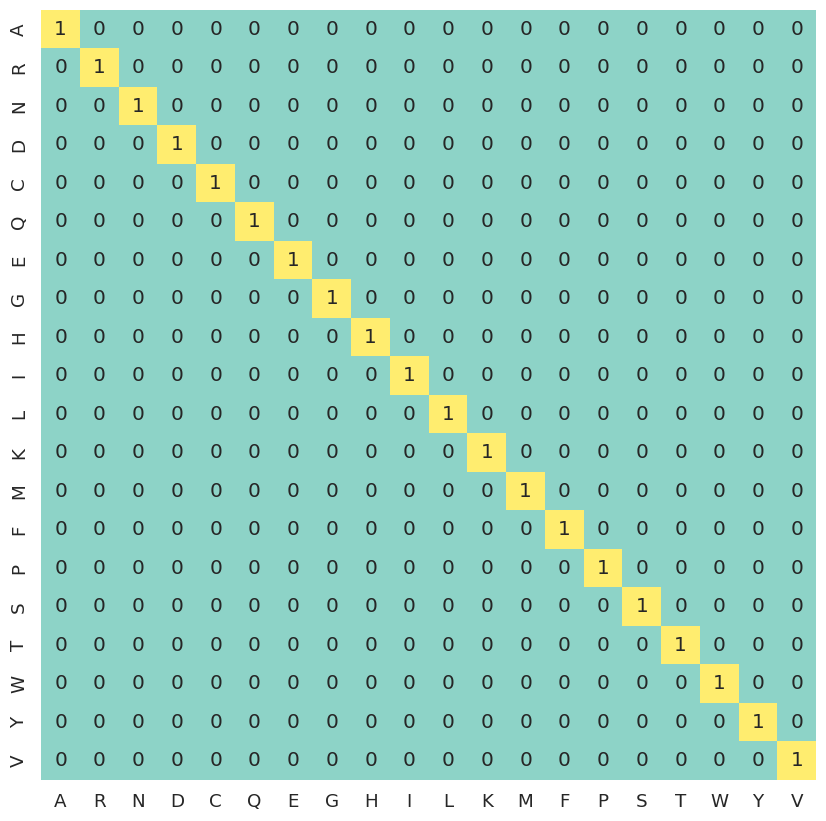

In [9]:
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 
           'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

one_hot_encodings = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # A
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # R
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # N
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # D
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # C
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Q
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # E
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # G
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # H
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # I
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # L
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # K
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # M
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # F
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # P
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],  # S
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # T
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # W
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # Y
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # V
])

# Plot heatmap of one-hot encodings
plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)  # Adjust font scale for better readability

# Plotting the heatmap
sns.heatmap(one_hot_encodings, annot=True, cmap="Set3", cbar=False, xticklabels=amino_acids, yticklabels=amino_acids, fmt=".0f")
plt.savefig('Plots/one_hot.png', dpi=600)